# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Importing databases

### Market Value (mv_ex_2)

In [2]:
#Reading and filtering by period the market value data
mv_ex_2 = pd.read_csv('https://github.com/MarianaLeonS/Sustainable-Finance/raw/main/Market_value.csv')
mv_ex_2 = mv_ex_2[(mv_ex_2['Date'] >= '2007-12-01') & (mv_ex_2['Date'] <= '2022-12-31')]
mv_ex_2['Date'] = pd.to_datetime(mv_ex_2['Date'])
print(mv_ex_2.shape)
mv_ex_2.head(1)


(181, 191)


,Date,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
95,2007-12-31,117637.4,10571.3,1171.1,3265.83,6803.47,4592.15,4177.58,8427.19,3100.59,...,29429.8,9496.63,3009.89,2663.35,2907.14,38547.03,5696.29,21236.39,9477.81,31281.12


### Market value only 2022

In [3]:
mv_2022 = pd.read_csv('https://github.com/MarianaLeonS/Sustainable-Finance/raw/main/Market_value.csv')
mv_2022 = mv_ex_2[(mv_2022['Date'] >= '2021-12-31') & (mv_2022['Date'] <= '2022-12-31')]
mv_2022['Date'] = pd.to_datetime(mv_2022['Date'])
print(mv_2022.shape)
mv_2022.head(1)

(13, 191)


C:\Users\castr\AppData\Local\Temp\ipykernel_31856\1415168081.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mv_2022 = mv_ex_2[(mv_2022['Date'] >= '2021-12-31') & (mv_2022['Date'] <= '2022-12-31')]
C:\Users\castr\AppData\Local\Temp\ipykernel_31856\1415168081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_2022['Date'] = pd.to_datetime(mv_2022['Date'])


,Date,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
263,2021-12-31,42031.31,19145.95,2089.88,912.49,6709.72,5138.79,699.79,16045.89,8118.7,...,72681.31,4729.8,442.1,19085.79,9605.38,30707.64,30619.23,31639.39,36468.33,10209.11


### Creation of returns

In [4]:
#Just using a simpler name for this dataset:
RI = pd.read_csv('https://raw.githubusercontent.com/juliw9/SustainableFinance/main/DS_RI_T_USD_M.csv')
sectors = pd.read_csv('https://raw.githubusercontent.com/Timiboylebg/finance/4dca1b79136eed4def2118dd5fd4715d50bd739c/Static_Carbon.csv', sep=';')
RI = pd.merge(RI, sectors, on='ISIN')
RI.head(1)

,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,...,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,Company,GICSSectorName,Country,Region
0,AN8068571086,SCHLUMBERGER,1858.26,2254.15,2334.75,2336.65,2245.09,2283.7,2262.67,2610.77,...,3433.33,3537.17,3344.15,4846.68,4801.97,4997.02,Schlumberger Limited,Energy,UNITED STATES,AMER


In [5]:
# Take only Energy and Utilities Sector
RI = RI[RI['GICSSectorName'].isin(['Energy','Utilities'])]

# See if we have null values
zero_count = (RI == 0).sum().sum()
print(f"Number of zero values in the DataFrame: {zero_count}")

#CHecking the types
print(RI.dtypes)

# We will keep ISIN and transpose the dataframe
RI = RI.rename(columns={'ISIN': ''})
RI.drop(["NAME", 'Company', 'GICSSectorName', 'Country', 'Region'], axis=1, inplace=True)
RI = RI.transpose()
RI.columns = RI.iloc[0]
RI = RI.drop(RI.index[0])
print(RI.shape)
RI.head(1)



Number of zero values in the DataFrame: 0
ISIN                    object
NAME                    object
2000-01-31 00:00:00    float64
2000-02-29 00:00:00    float64
2000-03-31 00:00:00    float64
                        ...   
2022-12-31 00:00:00    float64
Company                 object
GICSSectorName          object
Country                 object
Region                  object
Length: 282, dtype: object
(276, 190)


,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
2000-01-31 00:00:00,1858.26,524.6,14.4,15.4,1354.72,243.08,15.94,14.74,66.1,1526.85,...,2678.1,1784.97,432.56,1240.52,1873.77,592.12,2303.25,2379.91,1760.3,576.3


In [6]:
#We need to have the returns for each period, we sill use .pct_change()
returns = RI.pct_change()
returns = returns.dropna(axis=0, how ='all') #Remove the first line that has missing values by construction
returns = returns.dropna(axis=1) # Remove the columns that have a missing value
print(returns.shape)
returns

(275, 190)


,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
2000-02-29 00:00:00,0.213043,0.076230,-0.146528,-0.068831,-0.350397,-0.130739,-0.131744,-0.231343,-0.034342,0.210970,...,-0.124618,0.230771,-0.004392,0.038959,-0.100172,0.124856,-0.086348,0.072112,-0.087661,-0.189138
2000-03-31 00:00:00,0.035756,-0.081528,0.168430,-0.045328,0.143188,0.043445,0.000000,0.342454,-0.165126,0.081883,...,-0.019720,-0.053571,0.123624,0.006246,0.153333,0.203423,0.127211,0.054242,0.131676,-0.005671
2000-04-30 00:00:00,0.000814,-0.106429,-0.230501,-0.108108,-0.132082,-0.022678,-0.166908,-0.140039,-0.070745,0.016102,...,0.161322,0.292714,-0.064827,0.020379,-0.054916,-0.054994,0.072097,-0.146517,0.116712,-0.058237
2000-05-31 00:00:00,-0.039184,0.074843,-0.193665,-0.039312,0.064650,0.042324,-0.354727,0.084862,-0.076131,0.090333,...,0.040103,0.088235,0.306720,0.075000,0.101637,0.011433,0.006771,0.108336,0.014328,0.118878
2000-06-30 00:00:00,0.017198,0.000964,-0.139169,0.363171,0.237971,0.267231,0.280914,-0.041579,0.081530,-0.033431,...,-0.101207,-0.324325,-0.070282,0.023254,-0.073447,0.085470,-0.062133,0.006665,-0.087572,0.021670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00,0.030245,-0.125302,-0.073466,0.042934,0.047230,0.017171,0.069614,-0.028321,0.185281,-0.070060,...,0.011066,0.060906,0.006057,-0.072934,-0.084801,0.066937,0.000474,-0.001761,0.014621,-0.072402
2022-09-30 00:00:00,-0.054569,-0.106440,-0.184632,-0.260720,-0.228253,-0.216813,-0.108387,-0.149375,-0.172372,-0.234397,...,-0.117685,-0.182910,-0.020736,-0.070426,-0.173858,-0.087687,-0.132926,-0.147509,-0.132467,-0.145002
2022-10-31 00:00:00,0.449301,-0.085763,0.065999,-0.004640,0.076060,-0.053864,-0.310621,-0.068626,-0.172840,0.715424,...,-0.037059,0.132353,0.562158,-0.037229,0.092793,0.175011,0.021246,0.143205,0.017344,0.057706
2022-11-30 00:00:00,-0.009225,0.131216,0.173619,0.097902,0.483098,0.104944,0.593452,0.059574,0.286589,-0.090213,...,0.043700,-0.001443,-0.103192,0.043008,0.093971,0.071973,0.093902,0.060191,0.078482,0.046692


In [7]:
returns.reset_index(inplace=True)
returns.rename(columns={'index': 'Date'}, inplace=True)
returns['Date'] = pd.to_datetime(returns['Date'])
print(returns.shape)
returns.head(1)

(275, 191)


,Date,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
0,2000-02-29,0.213043,0.07623,-0.146528,-0.068831,-0.350397,-0.130739,-0.131744,-0.231343,-0.034342,...,-0.124618,0.230771,-0.004392,0.038959,-0.100172,0.124856,-0.086348,0.072112,-0.087661,-0.189138


### returns (returns_1)

In [8]:
returns_1 = returns[(returns['Date'] >= '2008-01-31') & (returns['Date'] <= '2021-12-31')]
returns_1.set_index('Date', inplace =True)
returns_1.head(1)

,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,-0.233506,-0.06725,-0.060014,-0.017656,0.003576,-0.167531,-0.098749,0.012178,-0.270438,-0.009128,...,-0.051161,0.00682,-0.034631,0.169853,-0.023119,-0.156648,-0.065285,-0.106484,-0.080637,-0.045586


### Expected Asset's Return (expected_returns_assets)

In [9]:
# expected returns per Asset
expected_returns_assets = returns_1.mean(axis=0)
expected_returns_assets


AN8068571086    0.001103
AT0000746409    0.009837
AU000000BPT9    0.011672
AU000000ERA9   -0.004196
AU000000ORG5    0.005702
                  ...   
US91913Y1001    0.010825
US92939U1060    0.012032
US9694571004    0.008269
US98389B1008    0.010689
ZAE000006896    0.010021
Length: 190, dtype: float64

### Covariance Matrix (cov_matrix)

In [10]:
#calculate the covariance matrix
cov_matrix = returns_1.cov()
cov_matrix.head()

,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
,,,,,,,,,,,,,,,,,,,,,
AN8068571086,0.011717,0.004589,0.009537,0.006273,0.007766,0.006102,0.003809,0.002327,0.004386,0.017824,...,0.000721,0.006999,0.010352,0.002876,0.003050,0.008587,0.000088,0.007038,0.000311,0.010978
AT0000746409,0.004589,0.009715,0.005877,0.006161,0.005376,0.003781,0.002084,0.001123,0.003556,0.005727,...,0.000978,0.003271,0.004803,0.002611,0.001992,0.003832,0.000609,0.004144,0.000764,0.007354
AU000000BPT9,0.009537,0.005877,0.024978,0.010351,0.010703,0.007158,0.003313,0.001368,0.006499,0.014794,...,0.001027,0.006399,0.010956,0.001835,0.003176,0.008885,-0.000107,0.007305,0.000405,0.014382
AU000000ERA9,0.006273,0.006161,0.010351,0.033849,0.007468,0.005521,0.002923,0.001645,0.006171,0.008058,...,0.000664,0.004841,0.004135,0.001789,0.001676,0.005479,0.000541,0.003091,0.001017,0.008775
AU000000ORG5,0.007766,0.005376,0.010703,0.007468,0.012516,0.005551,0.002453,0.001603,0.004331,0.012162,...,0.000868,0.006129,0.008060,0.002730,0.002559,0.005944,0.000188,0.005463,0.000502,0.010972


### Risk-free asset (rf_1)

In [11]:
rf = pd.read_excel('https://github.com/MarianaLeonS/Sustainable-Finance/raw/main/Risk_Free_Rate.xlsx')
rf.head(1)

,Unnamed: 0,RF
0,200001,0.41


In [12]:
# Name the Column Date
rf.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Convert 'Date' to datetime with the last day of each month
rf['Date'] = pd.to_datetime(rf['Date'], format='%Y%m') + pd.offsets.MonthEnd(1)

# Correct RF because 0.41 is in reality 0.41%
rf['RF'] = rf['RF'] / 100
# Display the first few rows to verify the changes
rf.head()

,Date,RF
0,2000-01-31,0.0041
1,2000-02-29,0.0043
2,2000-03-31,0.0047
3,2000-04-30,0.0046
4,2000-05-31,0.0050


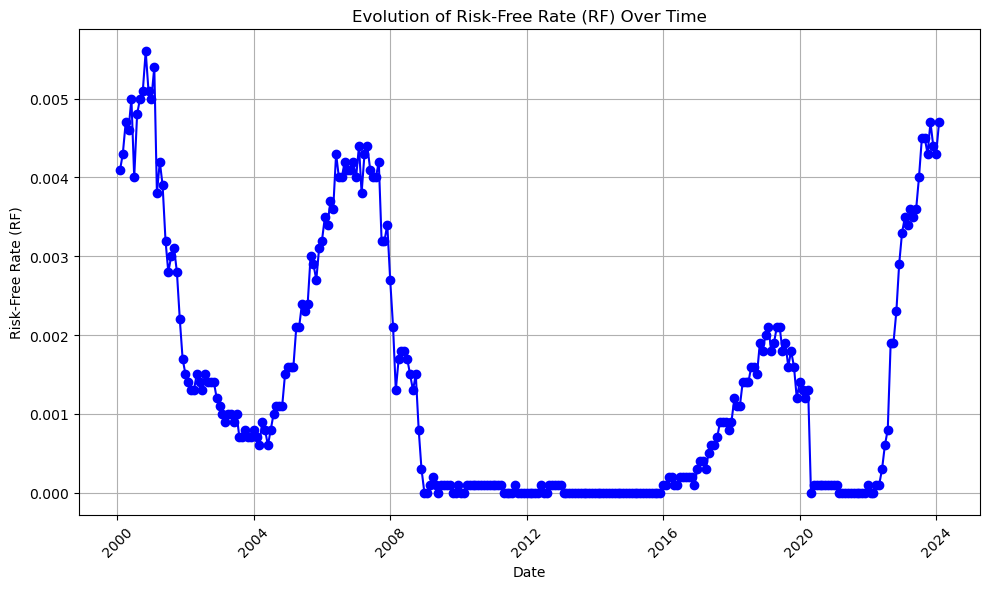

In [13]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(rf['Date'], rf['RF'], marker='o', linestyle='-', color='b')  # Line plot with markers
plt.title('Evolution of Risk-Free Rate (RF) Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Risk-Free Rate (RF)')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

plt.show()  # Display the plot

In [14]:
rf_1 = rf[(rf['Date'] >= '2008-01-31') & (rf['Date'] <= '2021-12-31')].copy()
rf_1.set_index('Date', inplace =True)
rf_1.head(1)

,RF
Date,
2008-01-31,0.0021


### Expected rf (expected_rf)

In [15]:
# Creating the expected rf
expected_rf = rf_1.mean() # We take the mean of rf between 2008 and 2022
expected_rf

RF    0.000434
dtype: float64

### Average Risk free end-2022 (avg_rf_2022)

In [16]:
rf_2 = rf[(rf['Date'] >= '2008-01-31') & (rf['Date'] <= '2022-12-31')]
rf_2.set_index('Date', inplace =True)
avg_rf_2022 = rf_2.mean()
avg_rf_2022

RF    0.000484
dtype: float64

### Average Risk free year 2022 only

In [17]:
rf_2022 = rf[(rf['Date'] >= '2022-01-31') & (rf['Date'] <= '2022-12-31')]
rf_2022.set_index('Date', inplace =True)
avg_rf_2022_only = rf_2022.mean()
avg_rf_2022_only

RF    0.001183
dtype: float64

# Checking for Energy and Utilities that have Carbon emissions data

## Importing the scope databases

In [18]:
scope_3 = pd.read_csv('https://raw.githubusercontent.com/juliw9/SustainableFinance/main/TC_Scope3.csv')
scope_1 = pd.read_csv('https://raw.githubusercontent.com/juliw9/SustainableFinance/main/TC_Scope2.csv')
scope_2 = pd.read_csv('https://raw.githubusercontent.com/juliw9/SustainableFinance/main/TC_Scope1.csv')

In [19]:
static_carbon = pd.read_csv('https://raw.githubusercontent.com/Timiboylebg/finance/4dca1b79136eed4def2118dd5fd4715d50bd739c/Static_Carbon.csv', sep=';')
static_carbon.head(1)

,Company,ISIN,GICSSectorName,Country,Region
0,Schlumberger Limited,AN8068571086,Energy,UNITED STATES,AMER


In [20]:
scope_1_merged = pd.merge(scope_1, static_carbon, on='ISIN')
scope_2_merged = pd.merge(scope_2, static_carbon, on='ISIN')
scope_3_merged = pd.merge(scope_3, static_carbon, on='ISIN')
scope_3_merged.head()

,ISIN,NAME,1999,2000,2001,2002,2003,2004,2005,2006,...,2016,2017,2018,2019,2020,2021,Company,GICSSectorName,Country,Region
0,AN8068571086,Schlumberger Limited,NaN,NaN,NaN,NaN,NaN,NaN,4.168041e+06,5.029795e+06,...,6.904570e+06,8.648838e+06,8.716874e+06,8.117563e+06,6739141.803,6841670.294,Schlumberger Limited,Energy,UNITED STATES,AMER
1,ARALUA010258,Aluar Aluminio Argentino S.A.I.C.,NaN,NaN,NaN,NaN,NaN,NaN,4.090752e+05,4.043601e+05,...,5.386519e+05,5.762160e+05,6.855264e+05,6.726419e+05,550818.824,548239.620,Aluar Aluminio Argentino S.A.I.C.,Materials,ARGENTINA,EM
2,ARP125991090,Banco BBVA Argentina S.A.,NaN,NaN,NaN,NaN,NaN,NaN,1.695871e+04,2.285564e+04,...,3.488199e+04,4.329747e+04,3.571320e+04,4.783006e+04,31495.292,74982.043,Banco BBVA Argentina S.A.,Financials,ARGENTINA,EM
3,ARSIDE010029,Ternium Argentina S.A.,NaN,NaN,NaN,NaN,NaN,NaN,1.254024e+06,1.276811e+06,...,1.212690e+06,1.548909e+06,1.662738e+06,1.275692e+06,1090691.046,2116629.333,Ternium Argentina S.A.,Materials,ARGENTINA,EM
4,AT00000VIE62,Flughafen Wien Aktiengesellschaft,NaN,NaN,NaN,NaN,NaN,NaN,3.766679e+04,4.362479e+04,...,6.200902e+04,7.195065e+04,7.094471e+04,6.563596e+04,26432.099,36382.334,Flughafen Wien Aktiengesellschaft,Industrials,AUSTRIA,EUR


In [21]:
scope_1_filtered = scope_1_merged[scope_1_merged['GICSSectorName'].isin(['Energy','Utilities'])]
scope_2_filtered = scope_2_merged[scope_1_merged['GICSSectorName'].isin(['Energy','Utilities'])]
scope_3_filtered = scope_3_merged[scope_1_merged['GICSSectorName'].isin(['Energy','Utilities'])]
scope_1_filtered

,ISIN,NAME,1999,2000,2001,2002,2003,2004,2005,2006,...,2016,2017,2018,2019,2020,2021,Company,GICSSectorName,Country,Region
0,AN8068571086,Schlumberger Limited,NaN,NaN,NaN,NaN,NaN,NaN,2.171508e+05,2.720474e+05,...,7.003494e+05,5.610000e+05,6.420000e+05,5.894568e+05,407790.670,254207.000,Schlumberger Limited,Energy,UNITED STATES,AMER
7,AT0000746409,VERBUND AG,NaN,NaN,NaN,NaN,NaN,NaN,1.487004e+03,1.795631e+03,...,9.082900e+05,4.516250e+05,4.110000e+05,3.920018e+05,406000.018,146090.000,VERBUND AG,Utilities,AUSTRIA,EUR
22,AU000000BPT9,Beach Energy Limited,NaN,NaN,NaN,NaN,NaN,NaN,2.754670e+03,5.006811e+03,...,5.780000e+02,5.010000e+02,2.401700e+04,2.114463e+04,56194.276,59665.756,Beach Energy Limited,Energy,AUSTRALIA,PAC
34,AU000000ERA9,Energy Resources of Australia Ltd,NaN,NaN,NaN,NaN,NaN,NaN,6.218320e+04,5.005456e+04,...,6.206516e+04,5.648813e+04,4.864628e+04,4.499333e+04,46707.960,42454.766,Energy Resources of Australia Ltd,Energy,AUSTRALIA,PAC
53,AU000000ORG5,Origin Energy Limited,NaN,NaN,NaN,NaN,NaN,NaN,2.268680e+04,2.290363e+04,...,1.271754e+06,1.826061e+06,2.089689e+06,2.288661e+06,2402843.914,2304722.000,Origin Energy Limited,Energy,AUSTRALIA,PAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,US91913Y1001,Valero Energy Corporation,NaN,NaN,NaN,NaN,NaN,NaN,3.194131e+06,3.356880e+06,...,2.410623e+06,3.276430e+06,4.039795e+06,3.384605e+06,2133683.369,4990000.000,Valero Energy Corporation,Energy,UNITED STATES,AMER
1991,US92939U1060,"WEC Energy Group, Inc.",NaN,NaN,NaN,NaN,NaN,NaN,8.067809e+03,7.670862e+03,...,6.604078e+06,7.708740e+06,7.500000e+04,1.100000e+05,74000.000,82000.000,"WEC Energy Group, Inc.",Utilities,UNITED STATES,AMER
2007,US9694571004,"The Williams Companies, Inc.",NaN,NaN,NaN,NaN,NaN,NaN,3.215780e+05,7.393963e+05,...,1.782436e+06,2.069300e+06,1.096000e+06,1.473282e+06,1503232.000,1659384.000,"The Williams Companies, Inc.",Energy,UNITED STATES,AMER
2010,US98389B1008,Xcel Energy Inc.,NaN,NaN,NaN,NaN,NaN,NaN,1.478328e+04,1.338946e+04,...,8.912786e+05,8.462539e+05,7.113020e+05,6.729260e+05,431294.900,700000.000,Xcel Energy Inc.,Utilities,UNITED STATES,AMER


In [22]:
print(scope_1_filtered.isnull().sum())
print(scope_2_filtered.isnull().sum())
print(scope_3_filtered.isnull().sum())

ISIN                0
NAME                0
1999              190
2000              190
2001              190
2002              190
2003              190
2004              190
2005                0
2006                0
2007                0
2008                0
2009                0
2010                0
2011                0
2012                0
2013                0
2014                0
2015                0
2016                0
2017                0
2018                0
2019                0
2020                0
2021                0
Company             0
GICSSectorName      0
Country             0
Region              0
dtype: int64
ISIN                0
NAME                0
1999              190
2000              190
2001              190
2002              190
2003              190
2004              190
2005                0
2006                0
2007                0
2008                0
2009                0
2010                0
2011                0
2012               

In [23]:
# Getting the unique firm IDs present in the filtered scope1 dataset
scope1_firms = scope_1_filtered['ISIN'].unique()
scope2_firms = scope_2_filtered['ISIN'].unique()
scope3_firms = scope_3_filtered['ISIN'].unique()


# Filtering the returns dataframe to include only firms present in the scope1_firms list
test_scope_1 = returns[returns.columns.intersection(scope1_firms)]
test_scope_2 = returns[returns.columns.intersection(scope2_firms)]
test_scope_3 = returns[returns.columns.intersection(scope3_firms)]
print(test_scope_1.shape)
print(test_scope_2.shape)
print(test_scope_3.shape)

(275, 190)
(275, 190)
(275, 190)


We see that we still have 190 colomns, or 190 Corporations! We can keep them all!

# Exercise 1

### Annualized Average returns

In [24]:
# Using returns from 2008 to 2022 (included)
returns_ex_1 = returns[(returns['Date'] >= '2008-01-31') & (returns['Date'] <= '2022-12-31')]
returns_ex_1.set_index('Date', inplace =True)

# expected returns per Asset
expected_returns_assets_ex_1 = returns_ex_1.mean(axis=0)
expected_returns_assets_ex_1


AN8068571086    0.005261
AT0000746409    0.007943
AU000000BPT9    0.012221
AU000000ERA9   -0.005527
AU000000ORG5    0.008178
                  ...   
US91913Y1001    0.013694
US92939U1060    0.011340
US9694571004    0.009621
US98389B1008    0.010433
ZAE000006896    0.010023
Length: 190, dtype: float64

In [25]:
#Annualizing the avg returns
ann_avg_ret_ex_1 = expected_returns_assets_ex_1 *12
ann_avg_ret_ex_1


AN8068571086    0.063134
AT0000746409    0.095317
AU000000BPT9    0.146657
AU000000ERA9   -0.066319
AU000000ORG5    0.098139
                  ...   
US91913Y1001    0.164324
US92939U1060    0.136078
US9694571004    0.115456
US98389B1008    0.125193
ZAE000006896    0.120275
Length: 190, dtype: float64

In [26]:
#Get more infos about the annualized returns:
ann_avg_ret_ex_1.describe()

count    190.000000
mean       0.076349
std        0.066180
min       -0.168423
25%        0.040046
50%        0.075367
75%        0.117695
max        0.381725
dtype: float64

In [27]:
#Isolating the max return company
max_index = ann_avg_ret_ex_1.idxmax()  # Get the index of the maximum value
max_value = ann_avg_ret_ex_1[max_index]  # Retrieve the maximum value using the index

print("Index of maximum value:", max_index)
print("Maximum value:", max_value)

Index of maximum value: US78454L1008
Maximum value: 0.3817246635366368


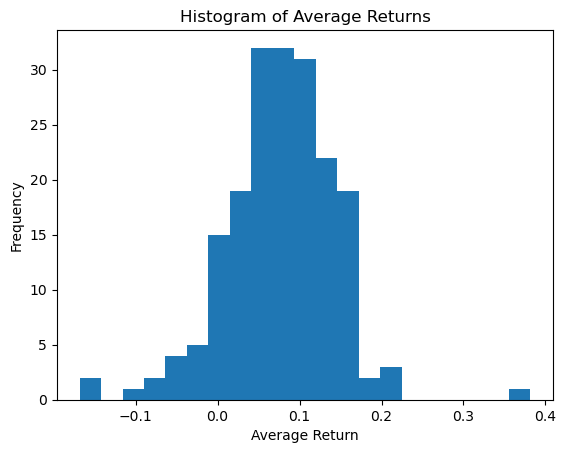

In [28]:
# Histogram
# Plotting the average returns in a histogram
plt.hist(ann_avg_ret_ex_1, bins='auto')
plt.title('Histogram of Average Returns')
plt.xlabel('Average Return')
plt.ylabel('Frequency')
plt.show()

### Annualized Volatility

In [29]:
# volatility per Asset
volatility_assets_ex_1 = returns_ex_1.std(axis=0)
volatility_assets_ex_1


AN8068571086    0.114386
AT0000746409    0.098747
AU000000BPT9    0.154774
AU000000ERA9    0.184075
AU000000ORG5    0.116813
                  ...   
US91913Y1001    0.121329
US92939U1060    0.048867
US9694571004    0.099204
US98389B1008    0.046325
ZAE000006896    0.160496
Length: 190, dtype: float64

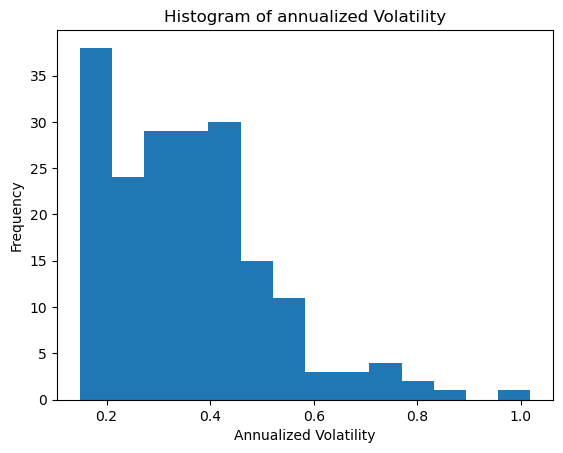

In [30]:
#Annualizing the volatility
ann_vol_ex_1 = volatility_assets_ex_1 * np.sqrt(12)

#Plotting the annualized volatility
plt.hist(ann_vol_ex_1, bins='auto')
plt.title('Histogram of annualized Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Frequency')
plt.show()

In [31]:
max_index = ann_vol_ex_1.idxmax()  # Get the index of the maximum value
max_value = ann_vol_ex_1[max_index]  # Retrieve the maximum value using the index

print("Index of maximum value:", max_index)
print("Maximum value:", max_value)

Index of maximum value: US78454L1008
Maximum value: 1.018692727962503


In [32]:
ann_vol_ex_1.describe()

count    190.000000
mean       0.358914
std        0.155822
min        0.147780
25%        0.240121
50%        0.341432
75%        0.431224
max        1.018693
dtype: float64

### Scatter plot (correlation)

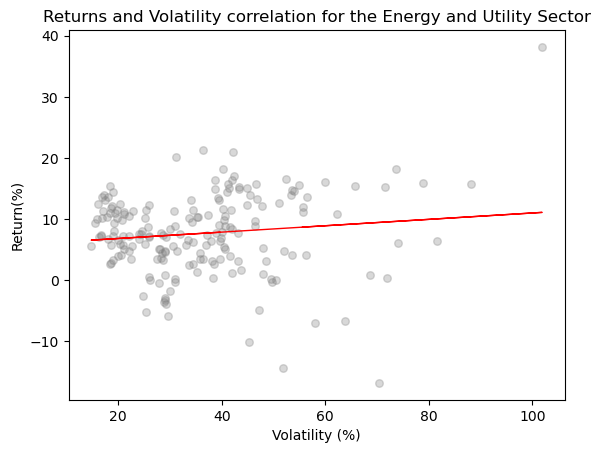

In [33]:
# Scatter plot
plt.scatter(ann_vol_ex_1 * 100, ann_avg_ret_ex_1 * 100, color='grey', alpha=0.3, s=30)  # aplpha and s for transparency and size

# Linear regression
slope, intercept = np.polyfit(ann_vol_ex_1 * 100, ann_avg_ret_ex_1 *100, 1)
regression_line = slope * np.array(ann_vol_ex_1*100) + intercept

# Adding the regression line to the scatter plot
plt.plot(ann_vol_ex_1*100, regression_line, color='red', linewidth=1)  # Plotting the regression line

# Adding title and labels
plt.title('Returns and Volatility correlation for the Energy and Utility Sector')
plt.xlabel('Volatility (%)')
plt.ylabel('Return(%)')

# Showing the plot
plt.show()

# Exercice 2

In [34]:
returns_ex_2 = returns[(returns['Date'] >= '2008-01-31') & (returns['Date'] <= '2022-12-31')]
returns_ex_2.set_index('Date', inplace =True)
print(returns_ex_2.shape)
returns_ex_2.tail()

(180, 190)


,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-31,0.030245,-0.125302,-0.073466,0.042934,0.047230,0.017171,0.069614,-0.028321,0.185281,-0.070060,...,0.011066,0.060906,0.006057,-0.072934,-0.084801,0.066937,0.000474,-0.001761,0.014621,-0.072402
2022-09-30,-0.054569,-0.106440,-0.184632,-0.260720,-0.228253,-0.216813,-0.108387,-0.149375,-0.172372,-0.234397,...,-0.117685,-0.182910,-0.020736,-0.070426,-0.173858,-0.087687,-0.132926,-0.147509,-0.132467,-0.145002
2022-10-31,0.449301,-0.085763,0.065999,-0.004640,0.076060,-0.053864,-0.310621,-0.068626,-0.172840,0.715424,...,-0.037059,0.132353,0.562158,-0.037229,0.092793,0.175011,0.021246,0.143205,0.017344,0.057706
2022-11-30,-0.009225,0.131216,0.173619,0.097902,0.483098,0.104944,0.593452,0.059574,0.286589,-0.090213,...,0.043700,-0.001443,-0.103192,0.043008,0.093971,0.071973,0.093902,0.060191,0.078482,0.046692
2022-12-31,0.040619,-0.052602,-0.091739,0.023355,-0.002207,0.006531,0.120091,0.039554,-0.071599,-0.021842,...,0.055736,-0.154624,0.212092,-0.066072,-0.031989,-0.050591,-0.054267,-0.039630,0.005331,-0.100363


### Equaly weighted Portfolio

#### Annulized Average Return

In [35]:
# EW monthly returns
EW_returns = returns_ex_2.mean(axis=1)
EW_returns.tail()


Date
2022-08-31    0.013489
2022-09-30   -0.125081
2022-10-31    0.095675
2022-11-30    0.079247
2022-12-31   -0.001164
dtype: float64

In [36]:
#Calculate annualized portfolio average return
EW_ann_ret = EW_returns.mean()*12
EW_ann_ret

0.07634852004747647

#### Annualized volatility

In [37]:
EW_ann_vol = EW_returns.std() * np.sqrt(12)
EW_ann_vol

0.19715626094424968

#### Sharpe ratio

In [38]:
EW_SR = (EW_ann_ret - (avg_rf_2022['RF'] * 12)) / EW_ann_vol
EW_SR

0.3577966687081628

#### Min and Max returns

In [39]:
# Maximum EW Portfolio return
max_EW_return = EW_returns.max() * 12
max_EW_return

2.467720973074295

In [40]:
# Minimum EW Portfolio return
min_EW_return = EW_returns.min() * 12
min_EW_return

-2.8287467702939244

#### Time serie

In [41]:
# Calculate cumulative returns over time
cumulative_EW_returns = [(1 + EW_returns.iloc[0])]

# Create a loop that calculates the cumulative return per month
for i in range(1, len(EW_returns)):
    cumulative_EW_returns.append(cumulative_EW_returns[i-1] * (1 + EW_returns.iloc[i]))

# Create a DataFrame with 'Date', 'Rp', and 'cumulative_returns' columns
df_cumulative_EW = pd.DataFrame({
    'Date': EW_returns.index,  # Assuming 'Date' is a datetime column in 'clean'
    'EW_returns': EW_returns.values,
    'cumulative_returns': cumulative_EW_returns
})

# Print the resulting DataFrame
df_cumulative_EW

,Date,EW_returns,cumulative_returns
0,2008-01-31,-0.081563,0.918437
1,2008-02-29,0.049275,0.963692
2,2008-03-31,-0.020537,0.943901
3,2008-04-30,0.070839,1.010766
4,2008-05-31,0.042050,1.053269
...,...,...,...
175,2022-08-31,0.013489,2.262480
176,2022-09-30,-0.125081,1.979486
177,2022-10-31,0.095675,2.168874
178,2022-11-30,0.079247,2.340751


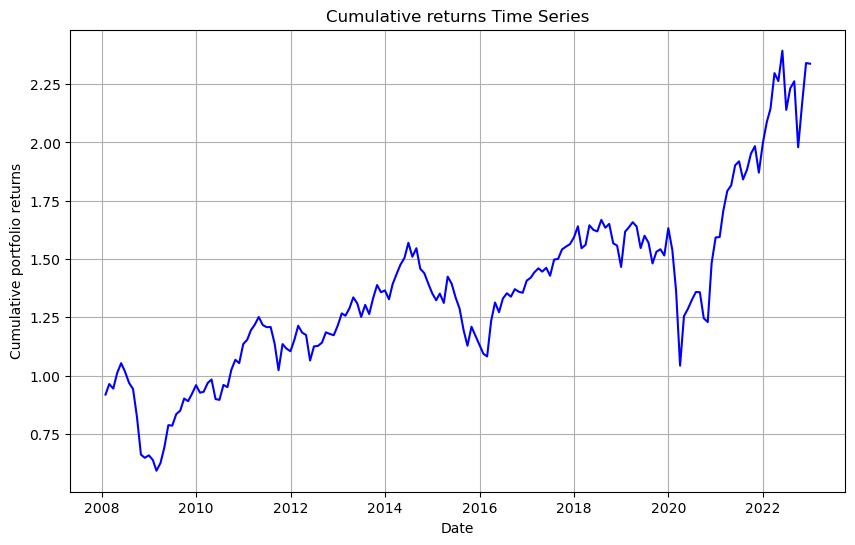

In [42]:
#Plotting the timeseries
# Plot the Rp time series
plt.figure(figsize=(10, 6))
plt.plot(df_cumulative_EW['Date'], df_cumulative_EW['cumulative_returns'], color='blue')
plt.title('Cumulative returns Time Series')
plt.xlabel('Date')
plt.ylabel('Cumulative portfolio returns')
plt.grid(True)
plt.show()

### Capitalisation Weighted Portfolio

In [43]:
# Initialize an empty DataFrame for the portfolio returns for all periods observed
portfolio_returns_all_periods = pd.DataFrame(columns=['Date', 'Return'])

# Loop through each date in the Market Value dataframe, excluding the last value
for i in range(len(mv_ex_2) - 1):
    # Get market values at time T
    market_values_T = mv_ex_2.iloc[i, 1:]
    total_market_value_T = market_values_T.sum()
    weights_T = market_values_T / total_market_value_T

    # Get the returns for time T+1
    returns_T_plus_1 = returns_ex_2.iloc[i , 1:] # It's i because returns_ex_2 starts the 31.01.2008 and mv_ex_2 starts the 31.12.2007 making the indexes the same

    # Calculate the portfolio return for T+1
    portfolio_return_T_plus_1 = (weights_T * returns_T_plus_1).sum()

    # Append the result to the DataFrame using concat
    new_row = pd.DataFrame({'Date': [mv_ex_2.iloc[i + 1 , 0]],
                            'Return': [portfolio_return_T_plus_1]})
    portfolio_returns_all_periods = pd.concat([portfolio_returns_all_periods, new_row], ignore_index=True)

# Output the DataFrame to a CSV file
portfolio_returns_all_periods

,Date,Return
0,2008-01-31,-0.096803
1,2008-02-29,0.039077
2,2008-03-31,-0.022154
3,2008-04-30,0.085899
4,2008-05-31,0.041057
...,...,...
175,2022-08-31,0.010223
176,2022-09-30,-0.103880
177,2022-10-31,0.118746
178,2022-11-30,0.055664


In [44]:
# Creating a clean array:
CW_returns = portfolio_returns_all_periods
CW_returns.set_index('Date', inplace =True)
CW_returns = CW_returns['Return'] #WE want a Serie like EW_returns
CW_returns

Date
2008-01-31   -0.096803
2008-02-29    0.039077
2008-03-31   -0.022154
2008-04-30    0.085899
2008-05-31    0.041057
                ...   
2022-08-31    0.010223
2022-09-30   -0.103880
2022-10-31    0.118746
2022-11-30    0.055664
2022-12-31   -0.018749
Name: Return, Length: 180, dtype: float64

#### Annualized Average Return

In [45]:
#Calculate annualized portfolio average return
CW_ann_ret = CW_returns.mean()*12
CW_ann_ret


0.0468480057733449

#### Annualized Volatility

In [46]:
CW_ann_vol = CW_returns.std() * np.sqrt(12)
CW_ann_vol

0.1727687361659867

#### Sharpe Ratio

In [47]:
CW_SR = (CW_ann_ret - (avg_rf_2022['RF'] * 12)) / CW_ann_vol
CW_SR

0.23755072831723426

#### Min and Max returns

In [48]:
# Maximum EW Portfolio return
max_CW_return = CW_returns.max() * 12
max_CW_return

1.6036130549186023

In [49]:
# Minimum EW Portfolio return
min_CW_return = CW_returns.min()* 12
min_CW_return

-2.3430762403520973

#### Time Serie

In [50]:
# Calculate cumulative returns over time
cumulative_CW_returns = [(1 + CW_returns.iloc[0])]

# Create a loop that calculates the cumulative return per month
for i in range(1, len(CW_returns)):
    cumulative_CW_returns.append(cumulative_CW_returns[i-1] * (1 + CW_returns.iloc[i]))

# Create a DataFrame with 'Date', 'Rp', and 'cumulative_returns' columns
df_cumulative_CW = pd.DataFrame({
    'Date': CW_returns.index,  # Assuming 'Date' is a datetime column in 'clean'
    'CW_returns': CW_returns.values,
    'cumulative_returns': cumulative_CW_returns
})

# Print the resulting DataFrame
df_cumulative_CW

,Date,CW_returns,cumulative_returns
0,2008-01-31,-0.096803,0.903197
1,2008-02-29,0.039077,0.938491
2,2008-03-31,-0.022154,0.917699
3,2008-04-30,0.085899,0.996528
4,2008-05-31,0.041057,1.037443
...,...,...,...
175,2022-08-31,0.010223,1.548584
176,2022-09-30,-0.103880,1.387717
177,2022-10-31,0.118746,1.552503
178,2022-11-30,0.055664,1.638922


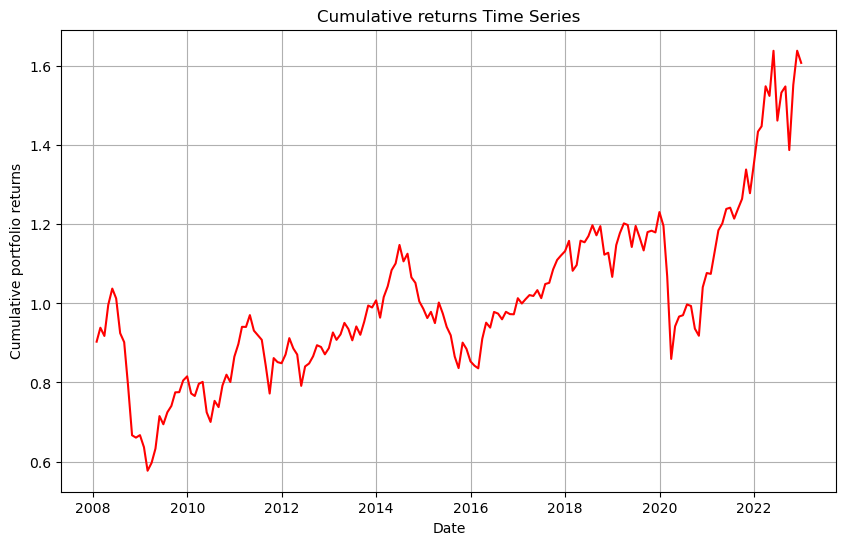

In [51]:
#Plotting the timeseries
# Plot the Rp time series
plt.figure(figsize=(10, 6))
plt.plot(df_cumulative_CW['Date'], df_cumulative_CW['cumulative_returns'], color='red')
plt.title('Cumulative returns Time Series')
plt.xlabel('Date')
plt.ylabel('Cumulative portfolio returns')
plt.grid(True)
plt.show()

# Exercise 3

## Global Minimum Variance Portfilio

### Minimisation function

In [52]:
#define objective function to calculate the minimum portfolio variance
def min_Variance(weights):
    weights = np.array(weights)
    var = np.dot(weights.T, np.dot(cov_matrix * 12, weights)) # We will use the annualized variance as objective
    return var

#define parameters and constraints
numAssets = len(expected_returns_assets)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # The weights == 1
initialWeights = np.array(numAssets*[1/numAssets]) # We use the equaly weighted portfolio to initialise the optimisation
positivity_bounds = tuple((0, 1) for x in range(numAssets)) # This is ensures that the weights are between 0 and 1 (i.e. positive weights)

#optimize function
result_long_only_gmv_portfolio = sco.minimize(min_Variance, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_long_only_gmv_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.005757681024478099
       x: [ 2.160e-17  4.333e-18 ...  0.000e+00  1.048e-17]
     nit: 21
     jac: [ 1.914e-02  1.851e-02 ...  1.262e-02  2.790e-02]
    nfev: 4012
    njev: 21

The 'fun' is the objective function and therefore represents the annualized variance of our GMV Portfolio which is 0.0057

### Expected Return

In [53]:
#expected return of the GMV portfolio
expected_GMV_return = np.dot(result_long_only_gmv_portfolio['x'], expected_returns_assets * 12) # We will also annualize the expected return
expected_GMV_return

0.07017451211981217

We obtain am annualized return of 7% for the GMV Portfolio

### Volatility

In [54]:
# Ex-ante Volatility
expected_GMV_vol = np.sqrt(np.dot(result_long_only_gmv_portfolio['x'].T, np.dot(cov_matrix * 12, result_long_only_gmv_portfolio['x']))) # We use the annualized volatility
expected_GMV_vol

0.07587938471336005

## Maximum return Portfolio

### Minimisation function

In [55]:
#define objective function to calculate maximum return portfolio
def max_return(weights):
    result = -np.dot(weights, expected_returns_assets * 12) # We maximise the annualized expected return
    return result

#define parameters and constraints
numAssets = len(expected_returns_assets)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # The summ of weights == 1
positivity_bounds = tuple((0, 1) for x in range(numAssets)) # Every weight is positive
initialWeights = np.array(numAssets*[1/numAssets]) # We initialise with the Equaly weighted Portfolio

#optimize function
result_max_return_portfolio = sco.minimize(max_return, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_max_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.3828319314553201
       x: [ 0.000e+00  1.067e-16 ...  1.591e-17  0.000e+00]
     nit: 5
     jac: [-1.323e-02 -1.180e-01 ... -1.283e-01 -1.203e-01]
    nfev: 955
    njev: 5

### Expected Return

In [56]:
# Expected annualized return
expected_MR_return = np.dot(result_max_return_portfolio['x'], expected_returns_assets * 12)
expected_MR_return

0.3828319314553201

### Volatility

In [57]:
# Ex-ante Volatility
expected_MR_vol = np.sqrt(np.dot(result_max_return_portfolio['x'].T, np.dot(cov_matrix * 12, result_max_return_portfolio['x']))) # We use annualized volatility
expected_MR_vol

1.0413980703065613

## Minimum Return Portfolio

Eventhough this Portfolio has not been asked, we wanted to go a little bit further to draw the bottom part of the efficient frontier

Minimisation function

In [58]:
#define objective function to calculate minimum return portfolio
def min_return(weights):
    result = np.dot(weights, expected_returns_assets * 12) # We minimise the annualized returns
    return result

#define parameters and constraints
numAssets = len(expected_returns_assets)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # summ of weights == 1
positivity_bounds = tuple((0, 1) for x in range(numAssets)) # We want all weights positive
initialWeights = np.array(numAssets*[1/numAssets]) # We initialise with EW portfolio

#optimize function
result_min_return_portfolio = sco.minimize(min_return, initialWeights, method='SLSQP', bounds= positivity_bounds, constraints=cons)
result_min_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.18600708445154548
       x: [ 4.337e-16  0.000e+00 ...  0.000e+00  0.000e+00]
     nit: 5
     jac: [ 1.323e-02  1.180e-01 ...  1.283e-01  1.203e-01]
    nfev: 955
    njev: 5

### Expected Return

In [59]:
# Expected annualized return
expected_Min_return = np.dot(result_min_return_portfolio['x'], expected_returns_assets * 12) # Annualized returns
expected_Min_return

-0.18600708445154548

### Volatility

In [60]:
# Ex-ante Volatility
expected_Min_vol = np.sqrt(np.dot(result_min_return_portfolio['x'].T, np.dot(cov_matrix * 12, result_min_return_portfolio['x']))) # We use annualized volatility
expected_Min_vol

0.5426110689039242

## Efficient Frontier (Upper part Ex-ante)

#### Code

In [61]:
# Defining Objective function
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12 , weights))) # We will use annualized Volatility

# Defining constraint for the intermediate dots (between min and max)
def return_constraint(weights):
    return np.dot(weights, expected_returns_assets * 12) - current_return # The constraints have to be saturated (meaning 0) here the return of the optimised portfolio has to be equal to the 'current_return' which is the objective return we fixed to have the same return difference between dots of the efficient frontier.

# Variables for the minimisation
target_returns = np.linspace(expected_MR_return, expected_GMV_return, 25)# Defining intermediate returns between min and max return equaly spaced on returns
results = []  # To store the results (volatility, return)
portfolio_weights = [] # To store the weights

for current_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': return_constraint},        # Portfolio return equals current target return
    )
    res = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
    if res.success:  # Check if the optimizer found a solution
        results.append((res.fun, current_return,res.x))  # Append (annualised volatility (which is 'fun'), return (current_return) and weights (res.x))
        portfolio_weights.append(res.x) # putting the weights in a seperated df for easy retreaval

# Convert results to a DataFrame
results_EF_full = pd.DataFrame(results, columns=['Volatility', 'Return','Weight portfolio'])
weights_EF_full = pd.DataFrame(portfolio_weights)

#### Graph

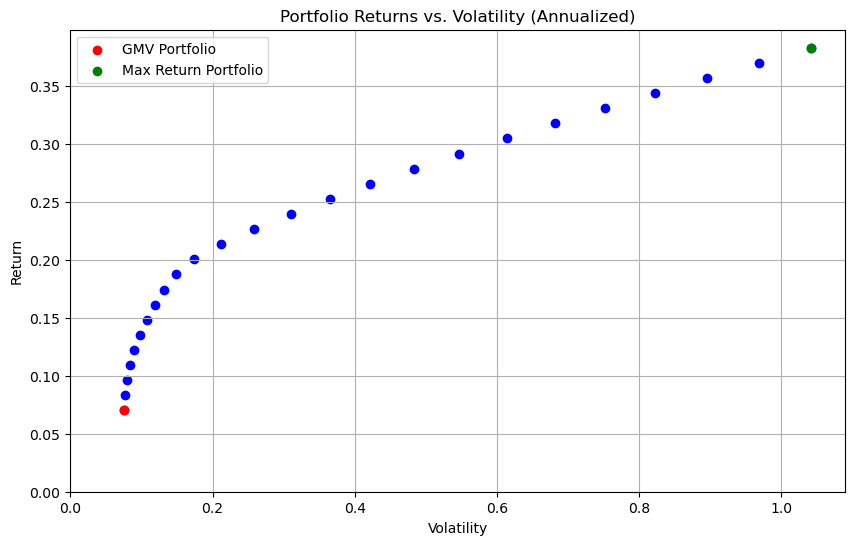

In [62]:
#Finding the GMV and Max return
index_gmv = results_EF_full['Volatility'].idxmin() # We retrieve the index of the gmv portfolio
index_max_return = results_EF_full['Return'].idxmax()

# Plot with colors
plt.figure(figsize=(10, 6))
plt.scatter(results_EF_full['Volatility'], results_EF_full['Return'], color='blue')
plt.scatter(results_EF_full.loc[index_gmv, 'Volatility'], results_EF_full.loc[index_gmv, 'Return'], color='red', label='GMV Portfolio')
plt.scatter(results_EF_full.loc[index_max_return, 'Volatility'], results_EF_full.loc[index_max_return, 'Return'], color='green', label='Max Return Portfolio')
plt.title('Portfolio Returns vs. Volatility (Annualized)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

## Efficient Frontier (Full, Ex-ante)

#### Code

In [63]:
# Defining Objective function
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12 , weights))) # We will use annualized Volatility

# Defining constraint for the intermediate dots (between min and max)
def return_constraint(weights):
    return np.dot(weights, expected_returns_assets * 12) - current_return # The constraints have to be saturated (meaning 0) here the return of the optimised portfolio has to be equal to the 'current_return' which is the objective return we fixed to have the same return difference between dots of the efficient frontier.

# Variables for the minimisation
target_returns = np.linspace(expected_MR_return, expected_Min_return, 50)# Defining intermediate returns between min and max return equaly spaced on returns
target_returns = np.append(target_returns, expected_GMV_return)# adding the GMV in the list
target_returns = np.sort(target_returns) # Sorting the list
results = []  # To store the results (volatility, return)
portfolio_weights = [] # To store the weights

for current_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': return_constraint},        # Portfolio return equals current target return
    )
    res = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
    if res.success:  # Check if the optimizer found a solution
        results.append((res.fun, current_return,res.x))  # Append (annualised volatility (which is 'fun'), return (current_return) and weights (res.x))
        portfolio_weights.append(res.x) # putting the weights in a seperated df for easy retreaval

# Convert results to a DataFrame
results_EF_full = pd.DataFrame(results, columns=['Volatility', 'Return','Weight portfolio'])
weights_EF_full = pd.DataFrame(portfolio_weights)

#### Graph

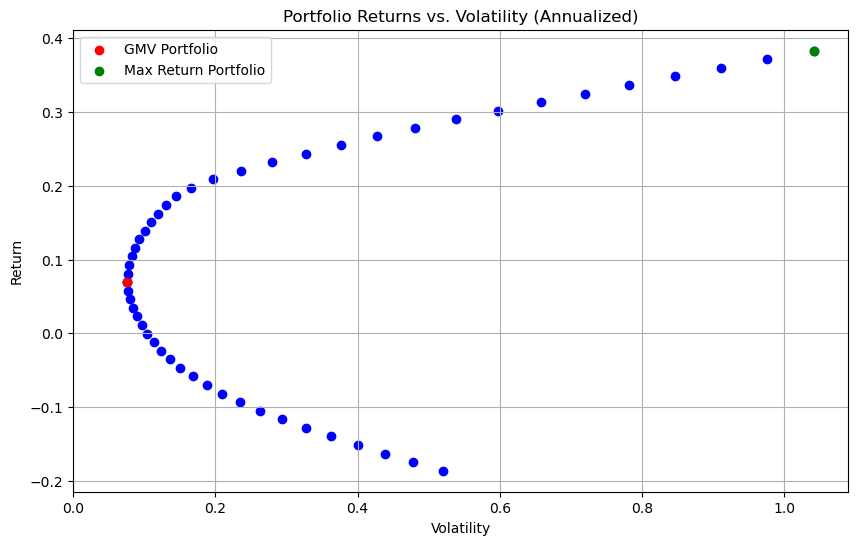

In [64]:
#Finding the GMV and Max return
index_gmv = results_EF_full['Volatility'].idxmin() # We retrieve the index of the gmv portfolio
index_max_return = results_EF_full['Return'].idxmax()

# Plot with colors
plt.figure(figsize=(10, 6))
plt.scatter(results_EF_full['Volatility'], results_EF_full['Return'], color='blue')
plt.scatter(results_EF_full.loc[index_gmv, 'Volatility'], results_EF_full.loc[index_gmv, 'Return'], color='red', label='GMV Portfolio')
plt.scatter(results_EF_full.loc[index_max_return, 'Volatility'], results_EF_full.loc[index_max_return, 'Return'], color='green', label='Max Return Portfolio')
plt.title('Portfolio Returns vs. Volatility (Annualized)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()

## Maximum Sharp Ratio

### Minimisation function

In [65]:
#define objective function to calculate maximum Sharp ratio Portfolio
def max_SR(weights):
    result = -((np.dot(weights, expected_returns_assets * 12) - (expected_rf['RF'] *12)) / (np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12 , weights))))) # We maximise the annualized Sharp ratio (mu - rf) / sigma
    return result

#define parameters and constraints
numAssets = len(expected_returns_assets)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # The summ of weights == 1
positivity_bounds = tuple((0, 1) for x in range(numAssets)) # Every weight is positive
initialWeights = np.array(numAssets*[1/numAssets]) # We initialise with the Equaly weighted Portfolio

#optimize function
result_max_SR_portfolio = sco.minimize(max_SR, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_max_SR_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.3319839254186037
       x: [ 1.148e-13  2.775e-14 ...  6.526e-15  1.507e-13]
     nit: 18
     jac: [ 1.937e+00  8.079e-01 ...  1.503e-01  1.415e+00]
    nfev: 3452
    njev: 18

### Expected Return

In [66]:
# Expected annualized return
expected_Max_SR_return = np.dot(result_max_SR_portfolio['x'], expected_returns_assets * 12) # Annualised return
expected_Max_SR_return

0.1436964819368816

### Volatility

In [67]:
# Ex-ante Volatility
expected_Max_SR_vol = np.sqrt(np.dot(result_max_SR_portfolio['x'].T, np.dot(cov_matrix * 12, result_max_SR_portfolio['x']))) # We use annualized volatility
expected_Max_SR_vol

0.10397223002238228

## EF + Sharp ratio (Upper part, ex-ante)

### Code

In [68]:
# Defining Objective function
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12 , weights))) # We will use annualized Volatility

# Defining constraint for the intermediate dots (between min and max)
def return_constraint(weights):
    return np.dot(weights, expected_returns_assets * 12) - current_return # The constraints have to be saturated (meaning 0) here the return of the optimised portfolio has to be equal to the 'current_return' which is the objective return we fixed to have the same return difference between dots of the efficient frontier.

# Variables for the minimisation
target_returns = np.linspace(expected_MR_return, expected_GMV_return, 25)# Defining intermediate returns between min and max return equaly spaced on returns
target_returns = np.append(target_returns, expected_Max_SR_return)# adding the Max Sharp ratio in the list
target_returns = np.sort(target_returns) # Sorting the list
results = []  # To store the results (volatility, return)
portfolio_weights = [] # To store the weights

for current_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': return_constraint},        # Portfolio return equals current target return
    )
    res = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
    if res.success:  # Check if the optimizer found a solution
        results.append((res.fun, current_return,res.x))  # Append (annualised volatility (which is 'fun'), return (current_return) and weights (res.x))
        portfolio_weights.append(res.x) # putting the weights in a seperated df for easy retreaval

# Convert results to a DataFrame
results_EF_full_SR = pd.DataFrame(results, columns=['Volatility', 'Return','Weight portfolio'])
weights_EF_full_SR = pd.DataFrame(portfolio_weights)

In [69]:
# Adding a column SR
results_EF_full_SR['Sharpe Ratio'] = (results_EF_full_SR['Return'] - expected_rf['RF'] * 12) / results_EF_full_SR['Volatility']
results_EF_full_SR.head()

,Volatility,Return,Weight portfolio,Sharpe Ratio
0,0.075830,0.070175,"[0.0, 6.39457161344511e-17, 7.305059524750976e...",0.856755
1,0.076963,0.083202,"[2.6594957441488583e-17, 0.0, 1.92970046033645...",1.013409
2,0.079859,0.096229,"[1.6338706259579835e-16, 1.6070198759188932e-1...",1.139784
3,0.084244,0.109257,"[1.3391955309004066e-16, 0.0, 0.0, 0.0, 0.0, 7...",1.235094
4,0.090243,0.122284,"[1.1141346533928887e-16, 8.392782229805434e-17...",1.297356


In [70]:
results_EF_full_SR.loc[results_EF_full_SR['Sharpe Ratio'].idxmax()]

Volatility                                                   0.103973
Return                                                       0.143696
Weight portfolio    [1.2915680064444187e-16, 0.0, 1.66902780584138...
Sharpe Ratio                                                 1.331974
Name: 6, dtype: object

### Graph

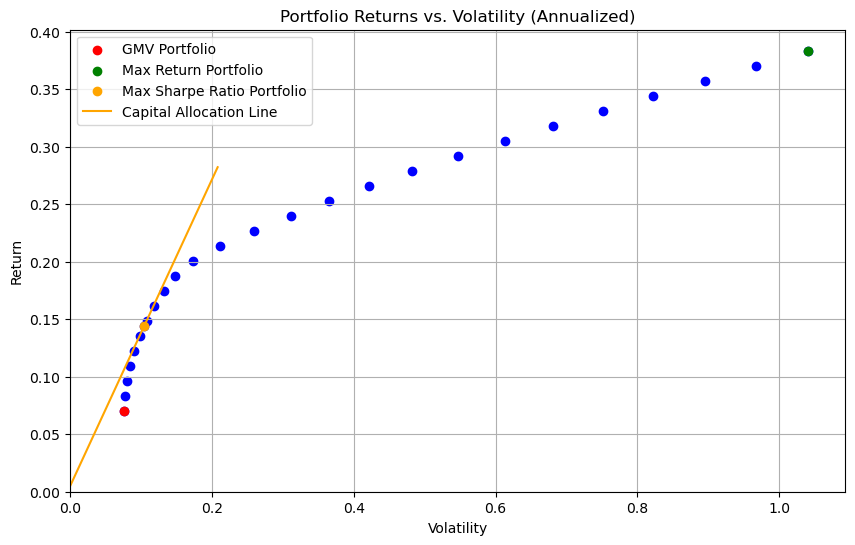

In [71]:
#Finding the GMV and Max return
index_gmv = results_EF_full_SR['Volatility'].idxmin() # We retrieve the index of the gmv portfolio
index_max_return = results_EF_full_SR['Return'].idxmax()
index_max_SR =  results_EF_full_SR['Sharpe Ratio'].idxmax()


# Plot with colors
plt.figure(figsize=(10, 6))
plt.scatter(results_EF_full_SR['Volatility'], results_EF_full_SR['Return'], color='blue')
plt.scatter(results_EF_full_SR.loc[index_gmv, 'Volatility'], results_EF_full_SR.loc[index_gmv, 'Return'], color='red', label='GMV Portfolio')
plt.scatter(results_EF_full_SR.loc[index_max_return, 'Volatility'], results_EF_full_SR.loc[index_max_return, 'Return'], color='green', label='Max Return Portfolio')
plt.scatter(results_EF_full_SR.loc[index_max_SR, 'Volatility'], results_EF_full_SR.loc[index_max_SR, 'Return'], color='orange', label='Max Sharpe Ratio Portfolio')

# Coordinates of Max SR for CAL
max_sharpe_vol = results_EF_full_SR.loc[index_max_SR, 'Volatility']
max_sharpe_ret = results_EF_full_SR.loc[index_max_SR, 'Return']

# Drawing the line
cal_x_end = max_sharpe_vol * 2
cal_y_end = (expected_rf['RF'] *12) + (cal_x_end * (max_sharpe_ret - expected_rf['RF'] * 12) / max_sharpe_vol)

# Tracer la ligne d'allocation de capital (CAL)
plt.plot([0, cal_x_end], [expected_rf['RF'] * 12, cal_y_end], color='orange', label='Capital Allocation Line')


plt.title('Portfolio Returns vs. Volatility (Annualized)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

## Ex-Post

### Ex-Post returns

In [72]:
results_EX_Post = results_EF_full_SR

In [73]:
returns_2 = returns[(returns['Date'] >= '2022-01-31') & (returns['Date'] <= '2022-12-31')]
returns_2.set_index('Date', inplace =True)

In [74]:
results_EX_Post['Ex-Post Return'] = results_EX_Post['Weight portfolio'].apply(lambda weights: np.dot(returns_2 * 12, weights.T).mean() ) # We make R01/22 * w and we take [0] so we have a float and not an array + We annualize the value
results_EX_Post.head()

,Volatility,Return,Weight portfolio,Sharpe Ratio,Ex-Post Return
0,0.075830,0.070175,"[0.0, 6.39457161344511e-17, 7.305059524750976e...",0.856755,-0.058562
1,0.076963,0.083202,"[2.6594957441488583e-17, 0.0, 1.92970046033645...",1.013409,-0.061125
2,0.079859,0.096229,"[1.6338706259579835e-16, 1.6070198759188932e-1...",1.139784,-0.066283
3,0.084244,0.109257,"[1.3391955309004066e-16, 0.0, 0.0, 0.0, 0.0, 7...",1.235094,-0.064762
4,0.090243,0.122284,"[1.1141346533928887e-16, 8.392782229805434e-17...",1.297356,-0.062728


### Ex-Post Volatility

For the ex-post volatility, we will need to compute the Return of each portfolio during the full period and then take the std of theses values.

In [75]:
results_EX_Post['Ex-Post Volatility'] = results_EX_Post['Weight portfolio'].apply(lambda weights: np.dot(returns_2 * 12, weights.T).std() ) # See Matrix theory
results_EX_Post.head()

,Volatility,Return,Weight portfolio,Sharpe Ratio,Ex-Post Return,Ex-Post Volatility
0,0.075830,0.070175,"[0.0, 6.39457161344511e-17, 7.305059524750976e...",0.856755,-0.058562,0.528088
1,0.076963,0.083202,"[2.6594957441488583e-17, 0.0, 1.92970046033645...",1.013409,-0.061125,0.537392
2,0.079859,0.096229,"[1.6338706259579835e-16, 1.6070198759188932e-1...",1.139784,-0.066283,0.550405
3,0.084244,0.109257,"[1.3391955309004066e-16, 0.0, 0.0, 0.0, 0.0, 7...",1.235094,-0.064762,0.571713
4,0.090243,0.122284,"[1.1141346533928887e-16, 8.392782229805434e-17...",1.297356,-0.062728,0.599162


### EX-Post Sharpe Ratio

In [76]:
# Adding a column Ex_Post SR
results_EX_Post['Ex-Post RF'] = (results_EX_Post['Ex-Post Return'] - avg_rf_2022_only['RF'] * 12) / results_EX_Post['Ex-Post Volatility']
results_EX_Post.head()

,Volatility,Return,Weight portfolio,Sharpe Ratio,Ex-Post Return,Ex-Post Volatility,Ex-Post RF
0,0.075830,0.070175,"[0.0, 6.39457161344511e-17, 7.305059524750976e...",0.856755,-0.058562,0.528088,-0.137784
1,0.076963,0.083202,"[2.6594957441488583e-17, 0.0, 1.92970046033645...",1.013409,-0.061125,0.537392,-0.140168
2,0.079859,0.096229,"[1.6338706259579835e-16, 1.6070198759188932e-1...",1.139784,-0.066283,0.550405,-0.146226
3,0.084244,0.109257,"[1.3391955309004066e-16, 0.0, 0.0, 0.0, 0.0, 7...",1.235094,-0.064762,0.571713,-0.138114
4,0.090243,0.122284,"[1.1141346533928887e-16, 8.392782229805434e-17...",1.297356,-0.062728,0.599162,-0.128393


In [77]:
### EX-Post Graph

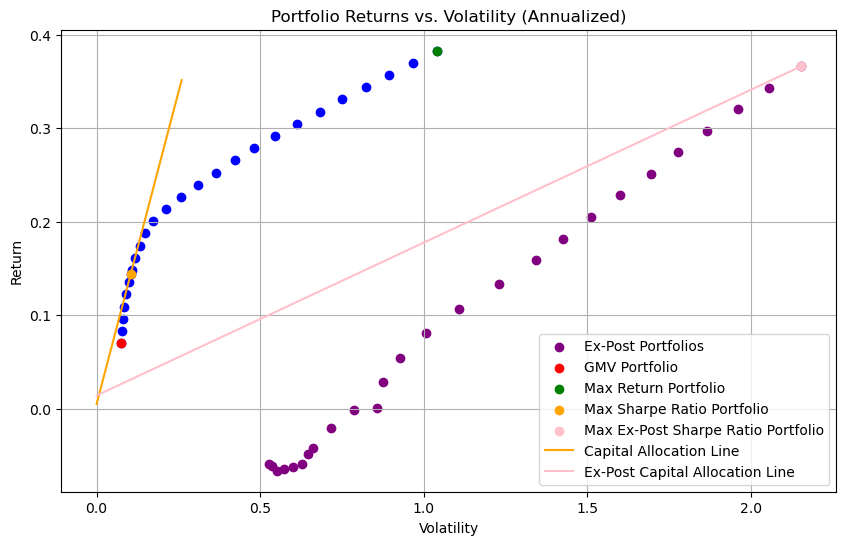

In [78]:
#Finding the GMV and Max return
index_gmv = results_EX_Post['Volatility'].idxmin() # We retrieve the index of the gmv portfolio
index_max_return = results_EX_Post['Return'].idxmax()
index_max_SR =  results_EX_Post['Sharpe Ratio'].idxmax()
index_max_Ex_post_SR = results_EX_Post['Ex-Post RF'].idxmax()


# Plot with colors
plt.figure(figsize=(10, 6))
plt.scatter(results_EX_Post['Volatility'], results_EX_Post['Return'], color='blue')
# Add the dots for the ex-post portfolios
plt.scatter(results_EX_Post['Ex-Post Volatility'], results_EX_Post['Ex-Post Return'], color='purple', label='Ex-Post Portfolios')

# Remarkable points
plt.scatter(results_EX_Post.loc[index_gmv, 'Volatility'], results_EX_Post.loc[index_gmv, 'Return'], color='red', label='GMV Portfolio')
plt.scatter(results_EX_Post.loc[index_max_return, 'Volatility'], results_EX_Post.loc[index_max_return, 'Return'], color='green', label='Max Return Portfolio')
plt.scatter(results_EX_Post.loc[index_max_SR, 'Volatility'], results_EX_Post.loc[index_max_SR, 'Return'], color='orange', label='Max Sharpe Ratio Portfolio')
plt.scatter(results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Volatility'], results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Return'], color='pink', label='Max Ex-Post Sharpe Ratio Portfolio')


# Coordinates of Max SR for CAL
max_sharpe_vol = results_EX_Post.loc[index_max_SR, 'Volatility']
max_sharpe_ret = results_EX_Post.loc[index_max_SR, 'Return']

# Drawing the line
cal_x_end = max_sharpe_vol * 2.5
cal_y_end = (expected_rf['RF'] *12) + (cal_x_end * (max_sharpe_ret - expected_rf['RF'] * 12) / max_sharpe_vol)

# Tracer la ligne d'allocation de capital (CAL)
plt.plot([0, cal_x_end], [expected_rf['RF'] * 12, cal_y_end], color='orange', label='Capital Allocation Line')




# Coordinates of Max Ex-Post SR for CAL
max_Ex_post_sharpe_vol = results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Volatility']
max_Ex_Post_sharpe_ret = results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Return']

# Drawing the line
Ex_Post_cal_x_end = max_Ex_post_sharpe_vol * 1.
Ex_Post_cal_y_end = (avg_rf_2022_only['RF'] *12) + (Ex_Post_cal_x_end * (max_Ex_Post_sharpe_ret - avg_rf_2022_only['RF'] * 12) / max_Ex_post_sharpe_vol)

# Tracer la ligne d'allocation de capital (CAL)
plt.plot([0, Ex_Post_cal_x_end], [avg_rf_2022_only['RF'] * 12, Ex_Post_cal_y_end], color='pink', label='Ex-Post Capital Allocation Line')


plt.title('Portfolio Returns vs. Volatility (Annualized)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
#plt.xlim(left=0)
#plt.ylim(bottom=0)
plt.show()

## Other points

### Ex-ante EW portfolio

In [79]:
# EW monthly returns
Ex_Ante_EW_returns = returns_1.mean(axis=1) #returns between 2008 and 2021

#Calculate annualized portfolio average return
Ex_Ante_EW_ann_ret = Ex_Ante_EW_returns.mean()*12
print(Ex_Ante_EW_ann_ret)

#Calculate volatility
Ex_Ante_EW_ann_vol = Ex_Ante_EW_returns.std() * np.sqrt(12)
print(Ex_Ante_EW_ann_vol)

#Calculate Sharpe Ratio
Ex_Ante_EW_SR = (Ex_Ante_EW_ann_ret - (expected_rf['RF'] * 12)) / Ex_Ante_EW_ann_vol
Ex_Ante_EW_SR

0.06852746987070875
0.19438409748874258


0.32574849399515815

### Ex-post EW portfolio

In [80]:
#EW 2022 monthly returns
Ex_Post_EW_returns = returns_2.mean(axis=1) #returns of only 2022
Ex_Post_EW_returns

#2022 EW annualized return
Ex_Post_EW_ann_ret = Ex_Post_EW_returns.mean()*12
print(Ex_Post_EW_ann_ret)

#2022 EW portfolio volatility
Ex_Post_EW_ann_vol = Ex_Post_EW_returns.std() * np.sqrt(12)
print(Ex_Post_EW_ann_vol)

#Calculate Sharpe Ratio
Ex_Post_EW_SR = (Ex_Post_EW_ann_ret - (avg_rf_2022_only['RF'] * 12)) / Ex_Post_EW_ann_vol
Ex_Post_EW_SR

0.18584322252222474
0.24023960730784627


0.7144667960694708

### Ex Ante CW portfolio

In [81]:
mv_ex_3 = mv_ex_2[mv_ex_2['Date'] <= '2022-01-01'].copy()
mv_ex_3.tail()

,Date,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
259,2021-08-31,39212.05,18638.77,1750.66,687.94,5727.89,4799.88,691.68,16103.71,9173.86,...,69660.94,3080.45,473.11,16035.67,9683.27,27109.07,29802.25,29997.34,37017.52,9725.53
260,2021-09-30,41574.04,17302.89,2463.66,919.94,6017.60,4811.28,710.64,14811.81,9031.82,...,65676.06,5622.97,497.80,16333.04,8911.70,28850.66,27821.32,31516.03,33652.29,11929.16
261,2021-10-31,45248.92,17750.04,2390.33,1136.76,6680.33,5468.07,926.95,15981.01,7925.24,...,66047.00,4953.09,500.69,17169.12,9076.89,31615.26,28408.03,34130.21,34793.05,10619.91
262,2021-11-30,40227.50,17724.51,1916.81,968.42,5994.10,4844.25,944.53,15351.52,8152.50,...,64754.07,4547.10,430.54,17540.14,8630.80,27367.46,27420.72,32550.67,34329.79,10417.18
263,2021-12-31,42031.31,19145.95,2089.88,912.49,6709.72,5138.79,699.79,16045.89,8118.70,...,72681.31,4729.80,442.10,19085.79,9605.38,30707.64,30619.23,31639.39,36468.33,10209.11


In [82]:
# Initialize an empty DataFrame for the portfolio returns for all periods observed
portfolio_returns_all_periods = pd.DataFrame(columns=['Date', 'Return'])

# Loop through each date in the Market Value dataframe, excluding the last value
for i in range(len(mv_ex_3) - 1):
    # Get market values at time T
    market_values_T = mv_ex_3.iloc[i, 1:]
    total_market_value_T = market_values_T.sum()
    weights_T = market_values_T / total_market_value_T

    # Get the returns for time T+1
    returns_T_plus_1 = returns_1.iloc[i , 1:] # It's i because returns_2 starts the 01.01.2008 and mv_ex_3 starts the 31.12.2007 making the indexes the same

    # Calculate the portfolio return for T+1
    portfolio_return_T_plus_1 = (weights_T * returns_T_plus_1).sum()

    # Append the result to the DataFrame using concat
    new_row = pd.DataFrame({'Date': [mv_ex_3.iloc[i + 1 , 0]],
                            'Return': [portfolio_return_T_plus_1]})
    portfolio_returns_all_periods = pd.concat([portfolio_returns_all_periods, new_row], ignore_index=True)

# Output the DataFrame to a CSV file
portfolio_returns_all_periods

,Date,Return
0,2008-01-31,-0.096803
1,2008-02-29,0.039077
2,2008-03-31,-0.022154
3,2008-04-30,0.085899
4,2008-05-31,0.041057
...,...,...
163,2021-08-31,0.021436
164,2021-09-30,0.019374
165,2021-10-31,0.058657
166,2021-11-30,-0.044754


In [83]:
# Creating a clean array:
Ex_Ante_CW_returns = portfolio_returns_all_periods
Ex_Ante_CW_returns.set_index('Date', inplace =True)
Ex_Ante_CW_returns = Ex_Ante_CW_returns['Return'] #WE want a Serie like EW_returns
Ex_Ante_CW_returns

Date
2008-01-31   -0.096803
2008-02-29    0.039077
2008-03-31   -0.022154
2008-04-30    0.085899
2008-05-31    0.041057
                ...   
2021-08-31    0.021436
2021-09-30    0.019374
2021-10-31    0.058657
2021-11-30   -0.044754
2021-12-31    0.059588
Name: Return, Length: 168, dtype: float64

In [84]:
#Calculate annualized portfolio average return
Ex_Ante_CW_ann_ret =Ex_Ante_CW_returns.mean()*12
print(Ex_Ante_CW_ann_ret)

#Volatility
Ex_Ante_CW_ann_vol = Ex_Ante_CW_returns.std() * np.sqrt(12)
print(Ex_Ante_CW_ann_vol)

0.03592891718419741
0.16736802003268061


### Ex-Post CW portfolio

In [85]:
# Initialize an empty DataFrame for the portfolio returns for all periods observed
portfolio_returns_2022 = pd.DataFrame(columns=['Date', 'Return'])

# Loop through each date in the Market Value dataframe, excluding the last value
for i in range(len(mv_2022) - 1):
    # Get market values at time T
    market_values_T = mv_2022.iloc[i, 1:]
    total_market_value_T = market_values_T.sum()
    weights_T = market_values_T / total_market_value_T

    # Get the returns for time T+1
    returns_T_plus_1 = returns_2.iloc[i , 1:]

    # Calculate the portfolio return for T+1
    portfolio_return_T_plus_1 = (weights_T * returns_T_plus_1).sum()

    # Append the result to the DataFrame using concat
    new_row = pd.DataFrame({'Date': [mv_2022.iloc[i + 1 , 0]],
                            'Return': [portfolio_return_T_plus_1]})
    portfolio_returns_2022 = pd.concat([portfolio_returns_2022, new_row], ignore_index=True)

# Output the DataFrame to a CSV file
portfolio_returns_2022

,Date,Return
0,2022-01-31,0.058743
1,2022-02-28,0.009371
2,2022-03-31,0.069885
3,2022-04-30,-0.015736
4,2022-05-31,0.074832
5,2022-06-30,-0.107704
6,2022-07-31,0.048320
7,2022-08-31,0.010223
8,2022-09-30,-0.103880
9,2022-10-31,0.118746


In [86]:
CW_ann_ret_2022 = portfolio_returns_2022['Return'].mean()*12
print(CW_ann_ret_2022)
CW_ann_vol_2022 = portfolio_returns_2022['Return'].std() * np.sqrt(12)
print(CW_ann_vol_2022)

0.19971524602140966
0.24119529533730277


### Ex ante assets returns and vol

In [87]:
Ex_Ante_assets_returns = returns_1.mean(axis=0)

#Annualized returns from 2008 to 2021
Ex_Ante_ann_assets_returns = Ex_Ante_assets_returns * 12
print(Ex_Ante_ann_assets_returns)

#Annualizing the volatility
Ex_Ante_assets_vol = returns_1.std(axis=0)
Ex_Ante_ann_assets_vol = Ex_Ante_assets_vol * np.sqrt(12)
print(Ex_Ante_ann_assets_vol)



AN8068571086    0.013233
AT0000746409    0.118049
AU000000BPT9    0.140066
AU000000ERA9   -0.050346
AU000000ORG5    0.068424
                  ...   
US91913Y1001    0.129898
US92939U1060    0.144379
US9694571004    0.099224
US98389B1008    0.128273
ZAE000006896    0.120254
Length: 190, dtype: float64

AN8068571086    0.374977
AT0000746409    0.341438
AU000000BPT9    0.547477
AU000000ERA9    0.637326
AU000000ORG5    0.387547
                  ...   
US91913Y1001    0.421060
US92939U1060    0.164698
US9694571004    0.344389
US98389B1008    0.157887
ZAE000006896    0.561760
Length: 190, dtype: float64


### Ex-Post assets return and vol

In [88]:
Ex_Post_assets_returns = returns_2.mean(axis=0)

#Annualized returns from 2008 to 2021
Ex_Post_ann_assets_returns = Ex_Post_assets_returns * 12
print(Ex_Post_ann_assets_returns)

#Annualizing the volatility
Ex_Post_assets_vol = returns_2.std(axis=0)
Ex_Post_ann_assets_vol = Ex_Post_assets_vol * np.sqrt(12)
print(Ex_Post_ann_assets_vol)


AN8068571086    0.761762
AT0000746409   -0.222933
AU000000BPT9    0.238932
AU000000ERA9   -0.289935
AU000000ORG5    0.514150
                  ...   
US91913Y1001    0.646291
US92939U1060    0.019865
US9694571004    0.342693
US98389B1008    0.082071
ZAE000006896    0.120573
Length: 190, dtype: float64

AN8068571086    0.610527
AT0000746409    0.352615
AU000000BPT9    0.355639
AU000000ERA9    0.667095
AU000000ORG5    0.606208
                  ...   
US91913Y1001    0.400380
US92939U1060    0.230621
US9694571004    0.340734
US98389B1008    0.201051
ZAE000006896    0.488936
Length: 190, dtype: float64


## Graphs

### Exactly asked by the homework

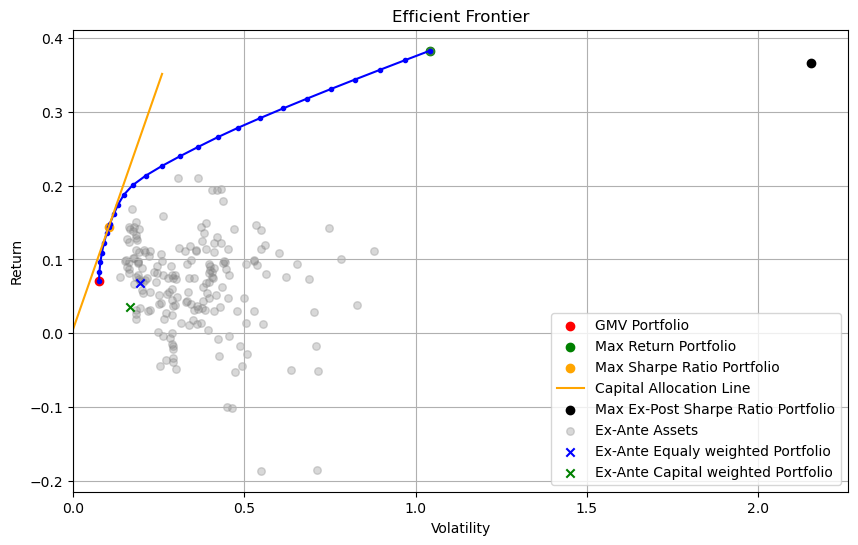

In [89]:
# Size
plt.figure(figsize=(10, 6))
#--------------------------------------------------------------------

#Remarkable points
index_gmv = results_EX_Post['Volatility'].idxmin() # We retrieve the index of the gmv portfolio
index_max_return = results_EX_Post['Return'].idxmax()
index_max_SR =  results_EX_Post['Sharpe Ratio'].idxmax()
index_max_Ex_post_SR = results_EX_Post['Ex-Post RF'].idxmax()
#---------------------------------------------------------------------

#Adding the GMV, max SR and Max returns ex-ante
plt.scatter(results_EX_Post.loc[index_gmv, 'Volatility'], results_EX_Post.loc[index_gmv, 'Return'], color='red', label='GMV Portfolio', alpha = 1)
plt.scatter(results_EX_Post.loc[index_max_return, 'Volatility'], results_EX_Post.loc[index_max_return, 'Return'], color='green', label='Max Return Portfolio')
plt.scatter(results_EX_Post.loc[index_max_SR, 'Volatility'], results_EX_Post.loc[index_max_SR, 'Return'], color='orange', label='Max Sharpe Ratio Portfolio')
#---------------------------------------------------------------------

# Doing the efficient curve
plt.plot(results_EX_Post['Volatility'], results_EX_Post['Return'], color='blue', marker='.', linestyle='-')
#----------------------------------------------------------------------

# Ex-Ante CAL
# Coordinates of Max SR for CAL
max_sharpe_vol = results_EX_Post.loc[index_max_SR, 'Volatility']
max_sharpe_ret = results_EX_Post.loc[index_max_SR, 'Return']
# Drawing the line
cal_x_end = max_sharpe_vol * 2.5
cal_y_end = (expected_rf['RF'] *12) + (cal_x_end * (max_sharpe_ret - expected_rf['RF'] * 12) / max_sharpe_vol)
# Tracer la ligne d'allocation de capital (CAL)
plt.plot([0, cal_x_end], [expected_rf['RF'] * 12, cal_y_end], color='orange', label='Capital Allocation Line')
#---------------------------------------------------------------------

# Best SR Ex-post
plt.scatter(results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Volatility'], results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Return'], color='black', label='Max Ex-Post Sharpe Ratio Portfolio')
#---------------------------------------------------------------------


# Ex-Ante expected returns for all assets
plt.scatter(Ex_Ante_ann_assets_vol, Ex_Ante_ann_assets_returns, color='grey', alpha=0.3, s=30, label='Ex-Ante Assets')
#------------------------------------------------------------------

# Ex-Ante EW and CW Portfolios
plt.scatter(Ex_Ante_EW_ann_vol, Ex_Ante_EW_ann_ret, color='blue', marker='x', label='Ex-Ante Equaly weighted Portfolio')
plt.scatter(Ex_Ante_CW_ann_vol, Ex_Ante_CW_ann_ret, color='green', marker='x', label='Ex-Ante Capital weighted Portfolio')
#----------------------------------------------------------------------

# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
# Show the plot
plt.show()

### Ex-Post Graph with Efficient frontier

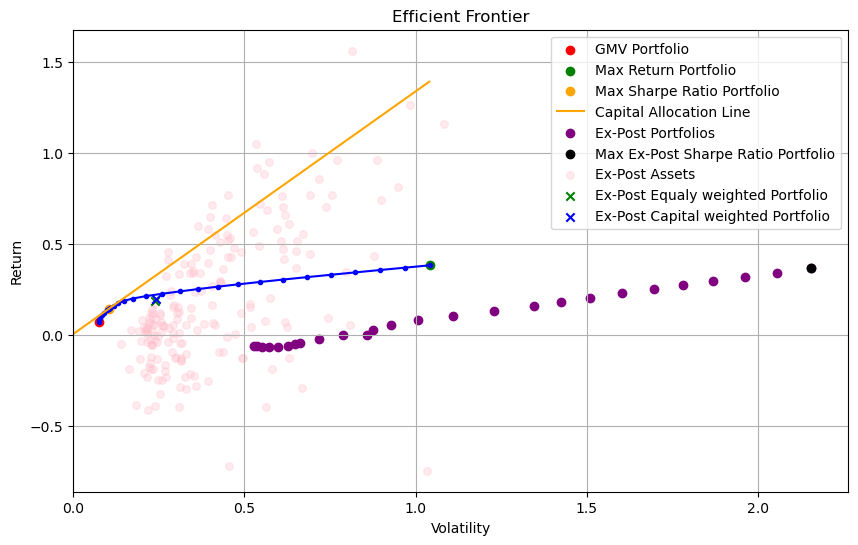

In [90]:
# Size
plt.figure(figsize=(10, 6))
#--------------------------------------------------------------------

#Remarkable points
index_gmv = results_EX_Post['Volatility'].idxmin() # We retrieve the index of the gmv portfolio
index_max_return = results_EX_Post['Return'].idxmax()
index_max_SR =  results_EX_Post['Sharpe Ratio'].idxmax()
index_max_Ex_post_SR = results_EX_Post['Ex-Post RF'].idxmax()
#---------------------------------------------------------------------

#Adding the GMV, max SR and Max returns ex-ante
plt.scatter(results_EX_Post.loc[index_gmv, 'Volatility'], results_EX_Post.loc[index_gmv, 'Return'], color='red', label='GMV Portfolio', alpha = 1)
plt.scatter(results_EX_Post.loc[index_max_return, 'Volatility'], results_EX_Post.loc[index_max_return, 'Return'], color='green', label='Max Return Portfolio')
plt.scatter(results_EX_Post.loc[index_max_SR, 'Volatility'], results_EX_Post.loc[index_max_SR, 'Return'], color='orange', label='Max Sharpe Ratio Portfolio')
#---------------------------------------------------------------------

# Doing the efficient curve
plt.plot(results_EX_Post['Volatility'], results_EX_Post['Return'], color='blue', marker='.', linestyle='-')
#----------------------------------------------------------------------

# Ex-Ante CAL
# Coordinates of Max SR for CAL
max_sharpe_vol = results_EX_Post.loc[index_max_SR, 'Volatility']
max_sharpe_ret = results_EX_Post.loc[index_max_SR, 'Return']
# Drawing the line
cal_x_end = max_sharpe_vol * 10
cal_y_end = (expected_rf['RF'] *12) + (cal_x_end * (max_sharpe_ret - expected_rf['RF'] * 12) / max_sharpe_vol)
# Tracer la ligne d'allocation de capital (CAL)
plt.plot([0, cal_x_end], [expected_rf['RF'] * 12, cal_y_end], color='orange', label='Capital Allocation Line')
#---------------------------------------------------------------------



# Ex-Ante expected returns for all assets
# plt.scatter(Ex_Ante_ann_assets_vol, Ex_Ante_ann_assets_returns, color='grey', alpha=0.3, s=30, label='Ex-Ante Assets')
#----------------------------------------------------------------------

# Ex post frontier portfolios
plt.scatter(results_EX_Post['Ex-Post Volatility'], results_EX_Post['Ex-Post Return'], color='purple', label='Ex-Post Portfolios')
#--------------------------------------------------------------------

# Best SR Ex-post
plt.scatter(results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Volatility'], results_EX_Post.loc[index_max_Ex_post_SR, 'Ex-Post Return'], color='black', label='Max Ex-Post Sharpe Ratio Portfolio')
#---------------------------------------------------------------------


# Ex-Post Assets returns
plt.scatter(Ex_Post_ann_assets_vol, Ex_Post_ann_assets_returns, color='pink', alpha=0.3, s=30, label='Ex-Post Assets')


# Ex-Post EW and CW Portfolios
plt.scatter(Ex_Post_EW_ann_vol, Ex_Post_EW_ann_ret, color='Green', marker='x', label='Ex-Post Equaly weighted Portfolio')
plt.scatter(CW_ann_vol_2022, CW_ann_ret_2022, color='blue', marker='x', label='Ex-Post Capital weighted Portfolio')
#----------------------------------------------------------------------





# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
# Show the plot
plt.show()

# Exercice 4

In [91]:
# Creating returns_ex_4
returns_ex_4 = returns.copy()
returns_ex_4.set_index('Date', inplace =True)
returns_ex_4.tail(1)

,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,0.040619,-0.052602,-0.091739,0.023355,-0.002207,0.006531,0.120091,0.039554,-0.071599,-0.021842,...,0.055736,-0.154624,0.212092,-0.066072,-0.031989,-0.050591,-0.054267,-0.03963,0.005331,-0.100363


## Functions

In [92]:
def expected_return(df,num_rows):
  lowerBound = max(0,num_rows-96)
  mu = 1/(num_rows)*df.iloc[lowerBound:num_rows,:].sum(axis = 0)
  return mu.to_frame().transpose()

def covariance_matrix(df,num_rows):
  mu = expected_return(df,num_rows)
  lowerBound = max(0,num_rows-96)
  vector = returns_ex_4.iloc[lowerBound,:] - mu
  cov_matrix = np.dot(vector.T,vector)
  for i in range(num_rows-1-lowerBound):
    vector = returns_ex_4.iloc[i+1+lowerBound,:] - mu
    cov_matrix += np.dot(vector.T,vector)
  cov_matrix /= num_rows

  return cov_matrix

covar_matrix = covariance_matrix(returns_ex_4,95)

In [93]:
def toMinimize(weights):
  weights = np.array(weights)
  #covar_matrix = covariance_matrix(df,num_rows)
  var = np.dot(weights.T, np.dot(covar_matrix * 12, weights))
  #print(f"{covar_matrix.iloc[3,3]}")
  return var

def findWeights(df,num_rows):
  #define parameters and constraints
  numAssets = len(df.columns)
  cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
  positivity_bounds = tuple((0, 1) for x in range(numAssets))
  initialWeights = np.array(numAssets*[1/numAssets])
  #covar_matrix = covariance_matrix(df,num_rows)
  #print(f"{covar_matrix.iloc[3,3]}")

  #optimize function
  result_max_return_portfolio = sco.minimize(toMinimize, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)

  results = []
  portfolio_weights = []
  current_return = []
  if result_max_return_portfolio.success:  # Check if the optimizer found a solution
        print("minimization successful")
        #results.append((result_max_return_portfolio.fun, current_return,result_max_return_portfolio.x))  # Append (volatility, return)
        #portfolio_weights.append(result_max_return_portfolio.x)
  else:
    print("no success")
  # Convert results to a DataFrame
  #results_df = pd.DataFrame(results, columns=['Volatility', 'Return','Weight portfolio'])
  #weights_df = pd.DataFrame(portfolio_weights)

  return result_max_return_portfolio.x

## Weights

Create the weights for every january

In [94]:
df_weights = pd.DataFrame(columns=returns_ex_4.columns)
num_rows = 95
year = 2008
while year < 2022:
  print(f"Year {year}:")
  covar_matrix = covariance_matrix(returns_ex_4,num_rows)
  df_weights.loc[year] = findWeights(returns_ex_4,num_rows)  # adding a row
  #df_weights.index = df_weights.index + 1  # shifting index
  #df_weights = df_weights.sort_index()
  num_rows += 12
  year += 1

Year 2008:
minimization successful
Year 2009:
minimization successful
Year 2010:
minimization successful
Year 2011:
minimization successful
Year 2012:
minimization successful
Year 2013:
minimization successful
Year 2014:
minimization successful
Year 2015:
minimization successful
Year 2016:
minimization successful
Year 2017:
minimization successful
Year 2018:
minimization successful
Year 2019:
minimization successful
Year 2020:
minimization successful
Year 2021:
minimization successful


In [95]:
df_weights

,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
2008,2.122989e-17,1.114351e-17,0.000000e+00,1.032875e-17,0.000000e+00,0.000000e+00,1.165090e-18,0.000000e+00,1.301926e-17,8.335248e-18,...,4.170761e-02,0.000000e+00,0.000000e+00,0.000000e+00,3.922522e-18,2.551602e-18,7.228556e-18,1.621944e-18,4.673514e-18,1.873463e-18
2009,2.456096e-17,0.000000e+00,0.000000e+00,0.000000e+00,9.460781e-18,1.789190e-17,0.000000e+00,1.377911e-17,4.483870e-18,0.000000e+00,...,2.515911e-02,0.000000e+00,1.079977e-19,9.743109e-03,0.000000e+00,4.455407e-18,0.000000e+00,2.976018e-18,4.882851e-18,0.000000e+00
2010,0.000000e+00,5.663028e-18,1.333914e-17,1.154309e-17,0.000000e+00,5.287436e-17,0.000000e+00,0.000000e+00,6.309047e-03,8.183647e-18,...,0.000000e+00,4.825623e-18,4.214767e-18,0.000000e+00,1.415336e-18,0.000000e+00,7.897377e-19,0.000000e+00,0.000000e+00,0.000000e+00
2011,0.000000e+00,7.321189e-18,7.344199e-18,0.000000e+00,0.000000e+00,0.000000e+00,1.375222e-18,0.000000e+00,1.089358e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.782855e-18,6.851231e-18
2012,0.000000e+00,3.529815e-18,0.000000e+00,0.000000e+00,1.519365e-18,0.000000e+00,0.000000e+00,3.185632e-17,2.469048e-03,0.000000e+00,...,5.177013e-04,9.049163e-19,2.050929e-18,0.000000e+00,2.080325e-18,7.466558e-18,7.291750e-02,0.000000e+00,4.088633e-18,6.450378e-18
2013,0.000000e+00,0.000000e+00,7.788689e-18,1.337222e-17,7.312186e-18,0.000000e+00,6.043075e-03,0.000000e+00,5.710567e-18,9.953604e-19,...,2.393480e-02,5.568838e-19,4.876799e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.528358e-19,0.000000e+00,0.000000e+00
2014,4.714831e-18,0.000000e+00,2.898736e-18,0.000000e+00,0.000000e+00,0.000000e+00,7.751911e-03,8.246049e-18,0.000000e+00,2.016066e-18,...,1.829511e-02,0.000000e+00,1.889881e-20,0.000000e+00,1.593017e-17,5.227044e-18,0.000000e+00,2.013937e-18,0.000000e+00,0.000000e+00
2015,3.493964e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.514188e-18,3.873399e-03,1.962993e-17,3.053873e-03,0.000000e+00,...,7.429536e-02,1.401289e-02,2.173697e-18,4.197035e-18,8.388283e-18,0.000000e+00,1.196369e-17,0.000000e+00,1.243627e-17,0.000000e+00
2016,1.640928e-17,1.017906e-17,0.000000e+00,3.187016e-18,0.000000e+00,1.759339e-17,1.774358e-02,4.585106e-18,0.000000e+00,0.000000e+00,...,9.218976e-02,7.650640e-03,0.000000e+00,0.000000e+00,0.000000e+00,2.762744e-18,7.575709e-19,0.000000e+00,0.000000e+00,3.200208e-18
2017,1.098036e-17,1.613495e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.058568e-02,5.956925e-02,0.000000e+00,0.000000e+00,...,1.186116e-01,0.000000e+00,4.060138e-18,6.803431e-19,1.941803e-18,3.269002e-02,0.000000e+00,0.000000e+00,3.048671e-02,2.133624e-18


Now, create a dataframe with all the weights (for every month):

In [96]:
df_Allweights = pd.DataFrame(columns = returns_ex_4.columns)
year = 2008
month = 1
index = 0
previous_weights = list(df_weights.iloc[0,:])

while year < 2022:

  if month == 1:
    previous_weights = list(df_weights.iloc[year-2008,:])
    df_Allweights.loc[index] = previous_weights
  else:
    previous_returns = list(returns_ex_4.iloc[index+94,:])
    previous_return = np.sum(list(a*b for a, b in zip(previous_returns, previous_weights)))
    p1 = list(a+1 for a in previous_returns)
    p2 = list(a/(1+previous_return) for a in p1)
    new_weights = list(a*b for a, b in zip(previous_weights,p2))
    df_Allweights.loc[index] = new_weights
    previous_weights = new_weights

  month = (month % 12) + 1
  if month == 1:
    year += 1
  index += 1
  #print(f"{index}")

#df_Allweights['Date'] = pd.to_datetime(df_Allweights['Date'].astype(str), format='%Y%m')

In [97]:
df_Allweights

,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
0,2.122989e-17,1.114351e-17,0.0,1.032875e-17,0.0,0.0,1.165090e-18,0.000000e+00,1.301926e-17,8.335248e-18,...,4.170761e-02,0.000000e+00,0.0,0.0,3.922522e-18,2.551602e-18,7.228556e-18,1.621944e-18,4.673514e-18,1.873463e-18
1,1.640082e-17,1.047602e-17,0.0,1.022634e-17,0.0,0.0,1.058314e-18,0.000000e+00,9.573205e-18,8.324252e-18,...,3.988566e-02,0.000000e+00,0.0,0.0,3.862033e-18,2.168856e-18,6.809887e-18,1.460653e-18,4.330514e-18,1.802149e-18
2,1.874288e-17,1.187824e-17,0.0,1.218908e-17,0.0,0.0,9.601291e-19,0.000000e+00,1.155492e-17,9.615069e-18,...,3.765508e-02,0.000000e+00,0.0,0.0,3.694119e-18,2.113573e-18,6.524844e-18,1.636216e-18,4.112623e-18,1.961578e-18
3,1.853559e-17,1.120012e-17,0.0,1.070861e-17,0.0,0.0,9.789945e-19,0.000000e+00,9.189358e-18,1.011991e-17,...,3.816058e-02,0.000000e+00,0.0,0.0,3.558137e-18,1.765635e-18,6.466282e-18,1.476497e-18,4.114866e-18,1.778386e-18
4,2.148403e-17,1.241155e-17,0.0,1.098339e-17,0.0,0.0,9.981803e-19,0.000000e+00,9.665933e-18,1.128198e-17,...,4.001125e-02,0.000000e+00,0.0,0.0,3.723008e-18,1.761335e-18,6.996394e-18,1.593883e-18,4.302501e-18,2.144224e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,8.702097e-18,0.000000e+00,0.0,1.209831e-18,0.0,0.0,0.000000e+00,4.803823e-17,0.000000e+00,0.000000e+00,...,2.873298e-18,7.685824e-18,0.0,0.0,5.051180e-18,0.000000e+00,1.198811e-02,4.532686e-18,6.454796e-18,0.000000e+00
164,8.364251e-18,0.000000e+00,0.0,1.118788e-18,0.0,0.0,0.000000e+00,4.752435e-17,0.000000e+00,0.000000e+00,...,2.938581e-18,7.304980e-18,0.0,0.0,5.004285e-18,0.000000e+00,1.192124e-02,4.395489e-18,6.397212e-18,0.000000e+00
165,9.027014e-18,0.000000e+00,0.0,1.526135e-18,0.0,0.0,0.000000e+00,4.530328e-17,0.000000e+00,0.000000e+00,...,2.828609e-18,9.081022e-18,0.0,0.0,4.739171e-18,0.000000e+00,1.136233e-02,4.794983e-18,5.978750e-18,0.000000e+00
166,9.956031e-18,0.000000e+00,0.0,1.910822e-18,0.0,0.0,0.000000e+00,4.953296e-17,0.000000e+00,0.000000e+00,...,2.882533e-18,8.105878e-18,0.0,0.0,4.891411e-18,0.000000e+00,1.175672e-02,5.261682e-18,6.261107e-18,0.000000e+00


## Returns

Now, compute all the returns after 2007:

In [98]:
returnsAfter7 = returns_ex_4.iloc[95:263,:]
weightedReturns = pd.DataFrame(returnsAfter7.values*df_Allweights.values, columns=returnsAfter7.columns, index=returnsAfter7.index)
weightedReturns.head()

,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8425871071,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,-4.957305e-18,-7.494043e-19,-0.0,-1.823630e-19,0.0,-0.0,-1.150514e-19,0.0,-3.520906e-18,-7.608041e-20,...,-0.002134,0.0,-0.0,0.0,-9.068503e-20,-3.997026e-19,-4.719131e-19,-1.727107e-19,-3.768586e-19,-8.540425e-20
2008-02-29,2.450540e-18,1.470965e-18,0.0,2.033289e-18,0.0,-0.0,-9.262767e-20,0.0,2.048588e-18,1.346466e-18,...,-0.002013,0.0,0.0,-0.0,-1.465330e-19,-4.305099e-20,-2.472795e-19,1.850327e-19,-1.940889e-19,1.707814e-19
2008-03-31,1.192205e-19,-4.808257e-19,-0.0,-1.291842e-18,0.0,-0.0,3.611063e-20,0.0,-2.203687e-18,6.831011e-19,...,0.001178,0.0,-0.0,0.0,-7.330539e-20,-3.168359e-19,5.534306e-20,-1.337104e-19,7.472692e-20,-1.518647e-19
2008-04-30,2.886881e-18,1.175873e-18,-0.0,2.433137e-19,0.0,-0.0,1.632582e-20,0.0,4.488803e-19,1.129745e-18,...,0.001736,0.0,0.0,0.0,1.542044e-19,-9.346825e-21,5.100653e-19,1.128191e-19,1.753078e-19,3.596945e-19
2008-05-31,1.239306e-19,1.112397e-18,0.0,3.103425e-18,0.0,0.0,8.952484e-20,-0.0,1.216964e-18,1.352387e-18,...,-0.000664,0.0,0.0,-0.0,1.403296e-19,7.740962e-20,1.252725e-19,1.140417e-19,1.054958e-19,1.867408e-19


And finally, compute the return of the entire portfolio:

In [99]:
weightedReturns["Monthly Returns"] = weightedReturns.sum(axis = 1)
weightedReturns.head()

,AN8068571086,AT0000746409,AU000000BPT9,AU000000ERA9,AU000000ORG5,AU0000088338,BMG2108M2182,BMG2178K1009,BMG5320C1082,BMG6359F1370,...,US8454671095,US88642R1095,US9026531049,US9026811052,US91913Y1001,US92939U1060,US9694571004,US98389B1008,ZAE000006896,Monthly Returns
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-31,-4.957305e-18,-7.494043e-19,-0.0,-1.823630e-19,0.0,-0.0,-1.150514e-19,0.0,-3.520906e-18,-7.608041e-20,...,0.0,-0.0,0.0,-9.068503e-20,-3.997026e-19,-4.719131e-19,-1.727107e-19,-3.768586e-19,-8.540425e-20,-0.007819
2008-02-29,2.450540e-18,1.470965e-18,0.0,2.033289e-18,0.0,-0.0,-9.262767e-20,0.0,2.048588e-18,1.346466e-18,...,0.0,0.0,-0.0,-1.465330e-19,-4.305099e-20,-2.472795e-19,1.850327e-19,-1.940889e-19,1.707814e-19,0.005788
2008-03-31,1.192205e-19,-4.808257e-19,-0.0,-1.291842e-18,0.0,-0.0,3.611063e-20,0.0,-2.203687e-18,6.831011e-19,...,0.0,-0.0,0.0,-7.330539e-20,-3.168359e-19,5.534306e-20,-1.337104e-19,7.472692e-20,-1.518647e-19,0.017615
2008-04-30,2.886881e-18,1.175873e-18,-0.0,2.433137e-19,0.0,-0.0,1.632582e-20,0.0,4.488803e-19,1.129745e-18,...,0.0,0.0,0.0,1.542044e-19,-9.346825e-21,5.100653e-19,1.128191e-19,1.753078e-19,3.596945e-19,-0.002865
2008-05-31,1.239306e-19,1.112397e-18,0.0,3.103425e-18,0.0,0.0,8.952484e-20,-0.0,1.216964e-18,1.352387e-18,...,0.0,0.0,-0.0,1.403296e-19,7.740962e-20,1.252725e-19,1.140417e-19,1.054958e-19,1.867408e-19,0.010060


## Annualized Average return, Volatility and Sharpe ratio

In [100]:
portfolioReturns = weightedReturns["Monthly Returns"]*12
annualizedAverage = portfolioReturns.mean()
print(f"The annualized average return is {annualizedAverage*100} %.")

The annualized average return is 7.099618978547278 %.


In [101]:
mini = portfolioReturns.min()
maxi = portfolioReturns.max()
print(f"The minimal return is {mini * 100} %")
print(f"The maximal return is {maxi* 100} %")

The minimal return is -123.34931148093382 %
The maximal return is 103.658848285844 %


In [102]:
volatility_m = weightedReturns["Monthly Returns"].std()
weightedReturns["sigma"] = volatility_m
volatility_y = volatility_m*np.sqrt(12)
print(f"The annualized volatility is {volatility_y}.")

The annualized volatility is 0.10643759138412048.


In [103]:
rf_ex_4 = rf[(rf['Date'] >= '2008-01-31') & (rf['Date'] <= '2022-12-31')].copy()
rf_ex_4.set_index('Date', inplace =True)
rf_ex_4.head()

,RF
Date,
2008-01-31,0.0021
2008-02-29,0.0013
2008-03-31,0.0017
2008-04-30,0.0018
2008-05-31,0.0018


In [104]:
rf_annual_ex_4 = rf_ex_4['RF'].mean()*12
rf_annual_ex_4

0.005806666666666667

In [105]:
print(f"The annualized average return of the risk free portfolio is: {rf_annual_ex_4*100} %.")
print(f"The annualized average return of our portfolio is: {annualizedAverage*100} %.")
print(f"The annualized volatility of our portfolio is: {volatility_y}.\n")
sharpe = (annualizedAverage - rf_annual_ex_4) / volatility_y
print(f"Therefore, the Sharpe Ratio is {sharpe}.")

The annualized average return of the risk free portfolio is: 0.5806666666666667 %.
The annualized average return of our portfolio is: 7.099618978547278 %.
The annualized volatility of our portfolio is: 0.10643759138412048.

Therefore, the Sharpe Ratio is 0.6124671018112854.


Boxplot to illustrate the distribution of annualized average returns:

In [106]:
CW_returns_ex_4 = CW_returns.loc[CW_returns.index <= '2021-12-31']
CW_returns_ex_4

Date
2008-01-31   -0.096803
2008-02-29    0.039077
2008-03-31   -0.022154
2008-04-30    0.085899
2008-05-31    0.041057
                ...   
2021-08-31    0.021436
2021-09-30    0.019374
2021-10-31    0.058657
2021-11-30   -0.044754
2021-12-31    0.059588
Name: Return, Length: 168, dtype: float64

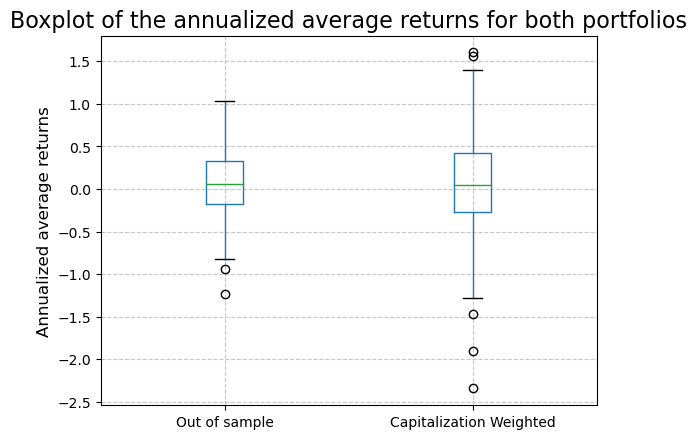

In [107]:
df_boxplot = portfolioReturns.to_frame()
df_boxplot = df_boxplot.rename(columns = {"Monthly Returns" : "Out of sample"})
CWReturns = CW_returns_ex_4.to_frame().rename(columns = {"Return": "Capitalization Weighted"})
CWReturns["Capitalization Weighted"] = CWReturns["Capitalization Weighted"]*12
df_boxplot = df_boxplot.merge(CWReturns, on=["Date"])

df_boxplot.boxplot(column = ["Out of sample", "Capitalization Weighted"])
plt.title('Boxplot of the annualized average returns for both portfolios', fontsize = 16)
plt.ylabel('Annualized average returns', fontsize = 12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [108]:
CW_returns_ex_4.mean() *12

0.03592891718419741

In [109]:
CW_returns_ex_4.std() * np.sqrt(12)

0.16736802003268061

In [110]:
CW_returns_ex_4.min() *12

-2.3430762403520973

In [111]:
CW_returns_ex_4.max() *12

1.6036130549186023

In [112]:
(CW_returns_ex_4.mean() *12 - rf_annual_ex_4) / (CW_returns_ex_4.std() * np.sqrt(12))

0.17997614186777744